In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [5]:
def get_random_h():
    z = torch.randn((50, 16))     
    return z

In [6]:
train_epoch = 500
batch_size = 50
test_reveal_period = 20
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [7]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm, device=device)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
        
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [12]:
models = {
    'Adam Discr+bn': Net(True, False, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [13]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [14]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [15]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % test_reveal_period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0707 D:0.6971 Adam Discr+dp: AE:1.0236 D:0.7035 Adam Discr+bn+dp: AE:1.2499 D:0.6971
Train Epoch: 1 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9676 D:0.0462 Adam Discr+dp: AE:0.7004 D:0.1421 Adam Discr+bn+dp: AE:0.9378 D:0.0399
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0726 D:0.0070 Adam Discr+dp: AE:0.7750 D:0.0229 Adam Discr+bn+dp: AE:1.0561 D:0.0115
Test losses: 
Adam Discr+bn: 3.01792574 / 2.39597106 / 0.02658835 
Adam Discr+dp: 2.02111411 / 1.81936443 / 0.10463597 
Adam Discr+bn+dp: 2.87506819 / 2.39887762 / 0.02716308 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0461 D:0.0051 Adam Discr+dp: AE:0.8054 D:0.0264 Adam Discr+bn+dp: AE:1.0501 D:0.0076
Train Epoch: 2 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0828 D:0.0036 Adam Discr+dp: AE:0.7915 D:0.0127 Adam Discr+bn+dp: AE:1.0712 D:0.0049
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0982 D:0.0089 Adam Discr+dp: AE:0.

Train Epoch: 14 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.3900 D:0.0080 Adam Discr+dp: AE:0.9730 D:0.0023 Adam Discr+bn+dp: AE:1.2072 D:0.0215
Test losses: 
Adam Discr+bn: 1.28715968 / 5.63490295 / 0.01158079 
Adam Discr+dp: 1.34507632 / 4.46647835 / 0.02963397 
Adam Discr+bn+dp: 1.17069006 / 4.98208523 / 0.00990784 

Train Epoch: 15 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.3108 D:0.0654 Adam Discr+dp: AE:1.0251 D:0.0008 Adam Discr+bn+dp: AE:1.2526 D:0.0018
Train Epoch: 15 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1570 D:0.0002 Adam Discr+dp: AE:1.0064 D:0.0162 Adam Discr+bn+dp: AE:1.1997 D:0.0003
Train Epoch: 15 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1410 D:0.0063 Adam Discr+dp: AE:0.9507 D:0.0468 Adam Discr+bn+dp: AE:1.1831 D:0.0004
Test losses: 
Adam Discr+bn: 1.32604074 / 4.45476389 / 0.00572059 
Adam Discr+dp: 1.34259200 / 4.93911171 / 0.03672083 
Adam Discr+bn+dp: 1.16478395 / 4.68351173 / 0.00558599 

Train Epoch: 16 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1

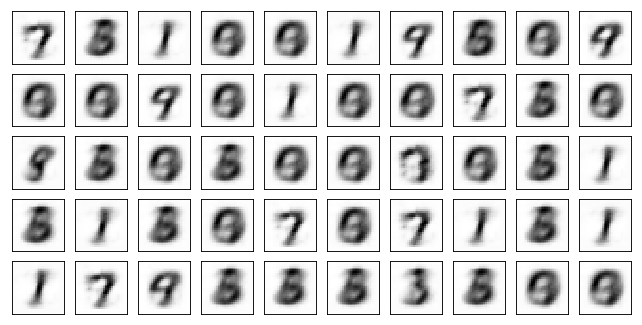

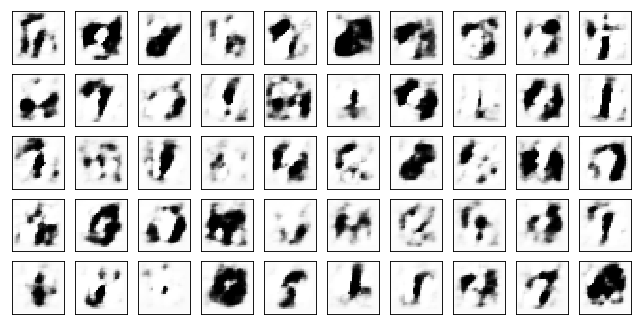

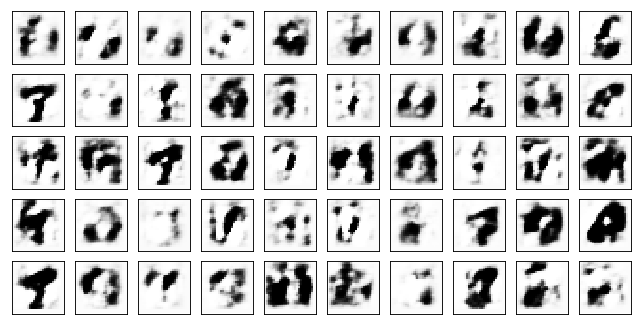

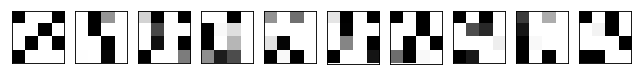

Model Adam Discr+dp:


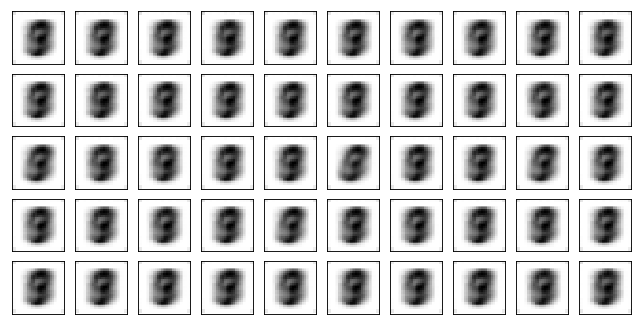

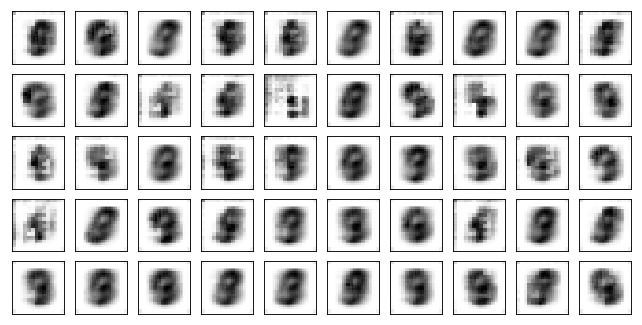

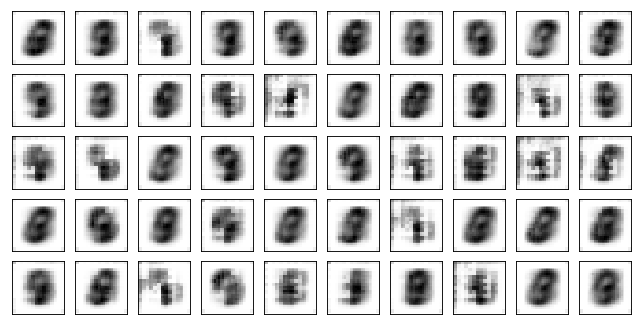

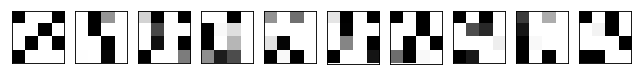

Model Adam Discr+bn+dp:


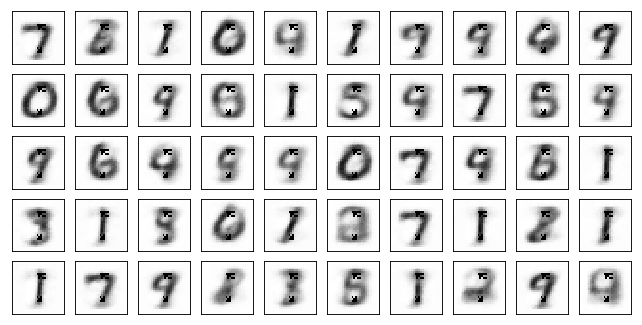

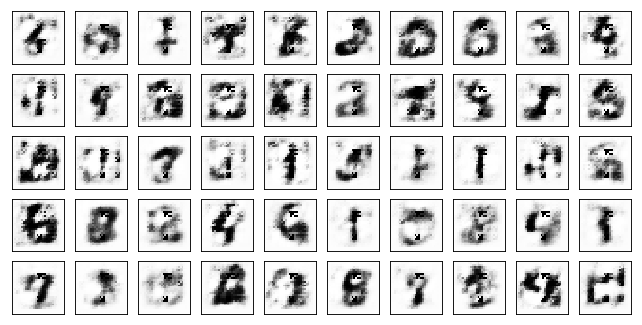

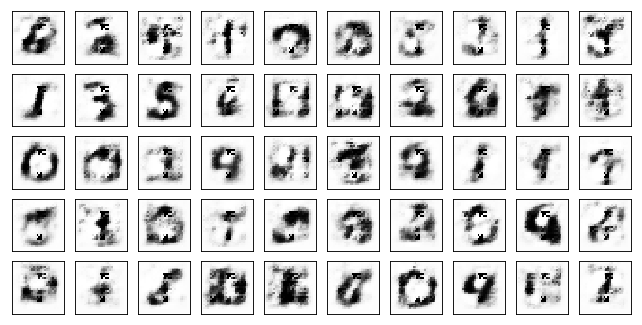

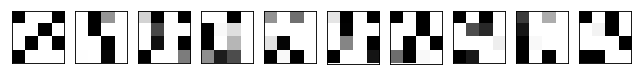

Test losses: 
Adam Discr+bn: 1.16482580 / 5.52288342 / 0.00068210 
Adam Discr+dp: 1.32944083 / 4.38166380 / 0.03015554 
Adam Discr+bn+dp: 1.04312885 / 4.57196617 / 0.00727590 

Train Epoch: 26 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.3137 D:0.0001 Adam Discr+dp: AE:0.9834 D:0.0013 Adam Discr+bn+dp: AE:1.1008 D:0.0013
Train Epoch: 26 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.2190 D:0.0002 Adam Discr+dp: AE:0.9830 D:0.1024 Adam Discr+bn+dp: AE:1.1435 D:0.0016
Train Epoch: 26 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.3122 D:0.0001 Adam Discr+dp: AE:0.9968 D:0.0033 Adam Discr+bn+dp: AE:1.1056 D:0.0004
Test losses: 
Adam Discr+bn: 1.19029450 / 5.73154116 / 0.00290116 
Adam Discr+dp: 1.30829215 / 4.22259808 / 0.02469196 
Adam Discr+bn+dp: 1.03958297 / 4.50928354 / 0.00816572 

Train Epoch: 27 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.4051 D:0.0000 Adam Discr+dp: AE:0.9896 D:0.0058 Adam Discr+bn+dp: AE:1.1178 D:0.0005
Train Epoch: 27 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 39 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.2688 D:0.0006 Adam Discr+dp: AE:1.0110 D:0.0112 Adam Discr+bn+dp: AE:1.1405 D:0.0008
Train Epoch: 39 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2675 D:0.0001 Adam Discr+dp: AE:0.9973 D:0.0012 Adam Discr+bn+dp: AE:1.0456 D:0.0004
Test losses: 
Adam Discr+bn: 1.13248813 / 5.46905327 / 0.00149964 
Adam Discr+dp: 1.32560897 / 3.97677445 / 0.02364448 
Adam Discr+bn+dp: 0.91075438 / 4.59781837 / 0.00762791 

Train Epoch: 40 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2889 D:0.0002 Adam Discr+dp: AE:0.9813 D:0.0280 Adam Discr+bn+dp: AE:1.0488 D:0.0006
Train Epoch: 40 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.3156 D:0.0001 Adam Discr+dp: AE:1.0137 D:0.0471 Adam Discr+bn+dp: AE:1.0753 D:0.0003
Train Epoch: 40 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.4151 D:0.0019 Adam Discr+dp: AE:1.0042 D:0.0019 Adam Discr+bn+dp: AE:1.0590 D:0.0006
Test losses: 
Adam Discr+bn: 1.11743593 / 5.82357121 / 0.00986482 
Adam Discr+dp: 1.29

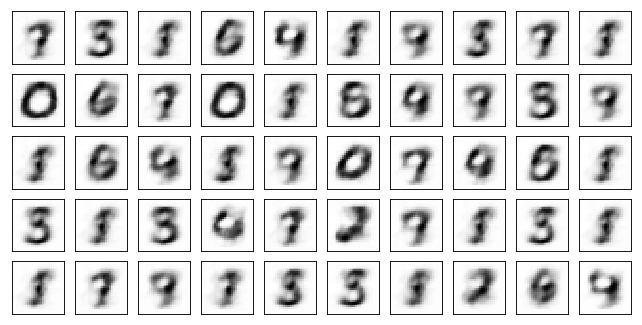

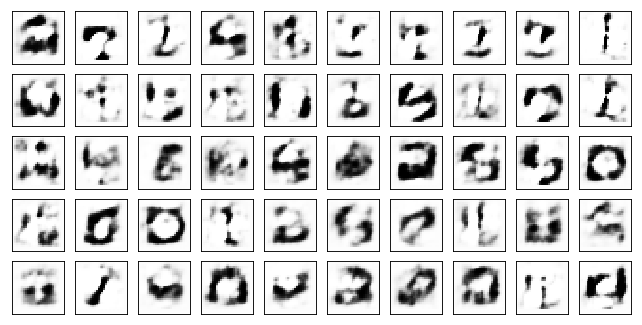

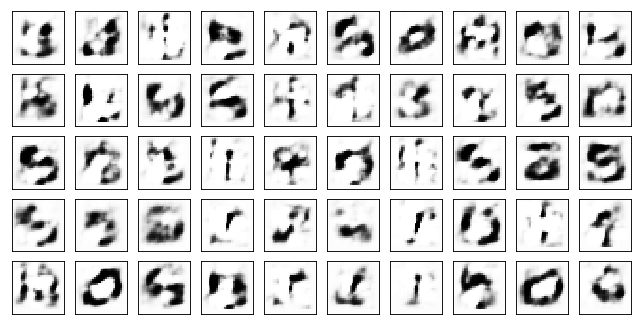

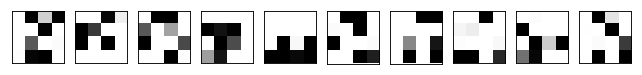

Model Adam Discr+dp:


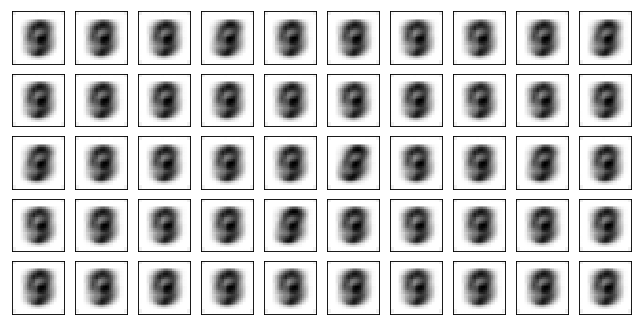

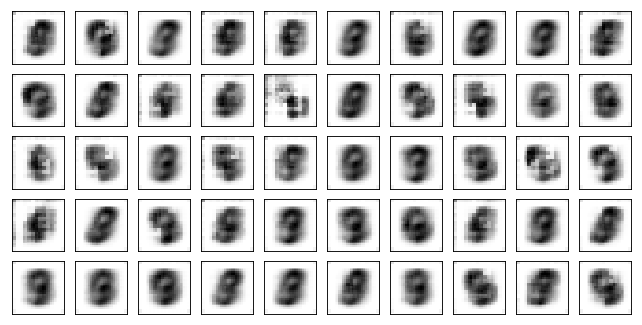

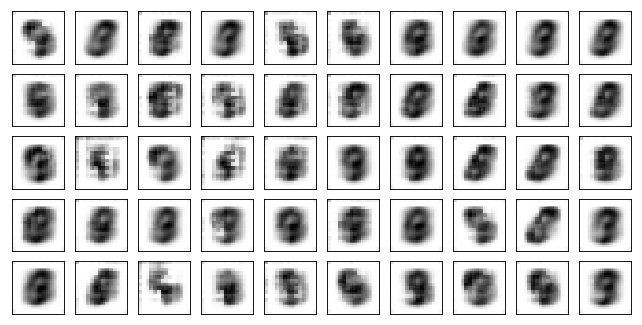

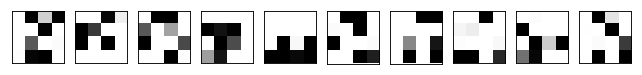

Model Adam Discr+bn+dp:


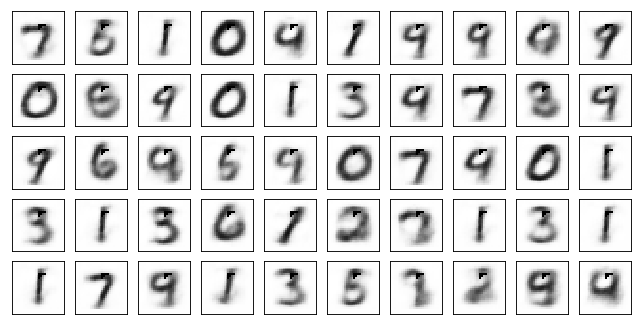

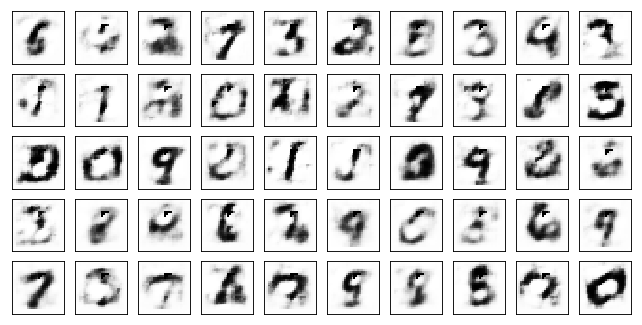

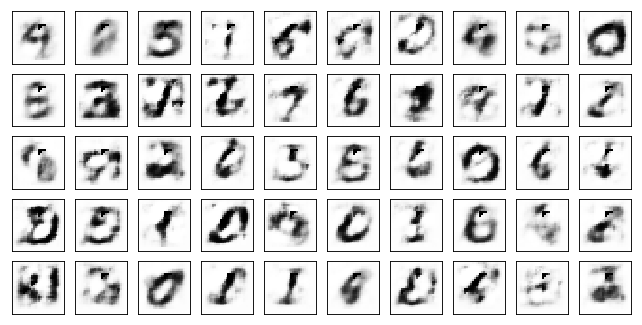

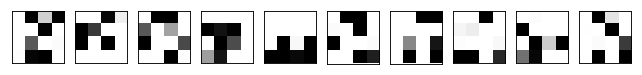

Test losses: 
Adam Discr+bn: 1.08123732 / 5.06687927 / 0.01246378 
Adam Discr+dp: 1.30617976 / 3.81518126 / 0.02359088 
Adam Discr+bn+dp: 0.87373883 / 4.51278257 / 0.00810788 

Train Epoch: 51 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1929 D:0.1326 Adam Discr+dp: AE:1.0353 D:0.0020 Adam Discr+bn+dp: AE:1.0369 D:0.0005
Train Epoch: 51 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0297 D:0.0101 Adam Discr+dp: AE:1.0279 D:0.0008 Adam Discr+bn+dp: AE:1.1064 D:0.0004
Train Epoch: 51 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0568 D:0.0004 Adam Discr+dp: AE:1.0103 D:0.0032 Adam Discr+bn+dp: AE:1.1138 D:0.0019
Test losses: 
Adam Discr+bn: 0.99614257 / 4.75661659 / 0.00716521 
Adam Discr+dp: 1.31318450 / 3.44592643 / 0.03204672 
Adam Discr+bn+dp: 0.86717248 / 4.70417643 / 0.00822088 

Train Epoch: 52 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0949 D:0.0004 Adam Discr+dp: AE:1.0433 D:0.0156 Adam Discr+bn+dp: AE:1.0961 D:0.0024
Train Epoch: 52 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 64 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0302 D:0.0006 Adam Discr+dp: AE:0.9678 D:0.0207 Adam Discr+bn+dp: AE:1.1054 D:0.0002
Train Epoch: 64 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9869 D:0.0008 Adam Discr+dp: AE:1.0265 D:0.0011 Adam Discr+bn+dp: AE:1.0710 D:0.0004
Test losses: 
Adam Discr+bn: 0.85869354 / 4.18304539 / 0.00556111 
Adam Discr+dp: 1.30714631 / 3.51503587 / 0.02235227 
Adam Discr+bn+dp: 0.83222562 / 4.82373142 / 0.00650375 

Train Epoch: 65 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9941 D:0.0008 Adam Discr+dp: AE:1.0892 D:0.0033 Adam Discr+bn+dp: AE:1.1507 D:0.0060
Train Epoch: 65 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9645 D:0.0005 Adam Discr+dp: AE:1.0056 D:0.0025 Adam Discr+bn+dp: AE:1.0821 D:0.0003
Train Epoch: 65 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1096 D:0.0006 Adam Discr+dp: AE:0.9539 D:0.0072 Adam Discr+bn+dp: AE:1.1178 D:0.0002
Test losses: 
Adam Discr+bn: 0.87605232 / 4.55896282 / 0.00544147 
Adam Discr+dp: 1.32

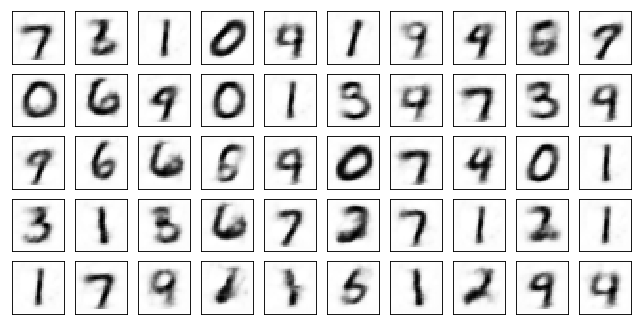

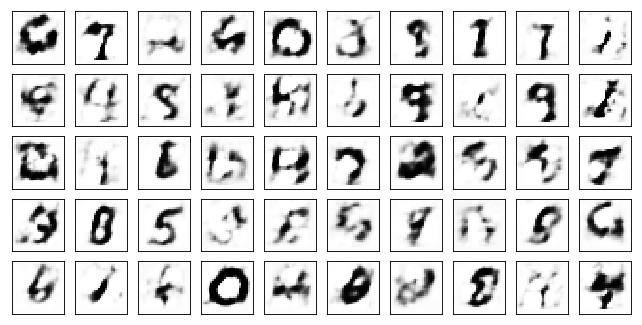

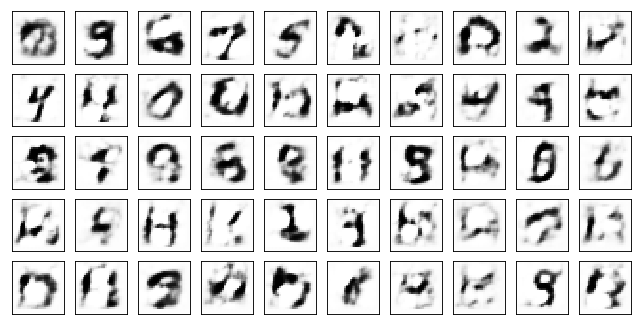

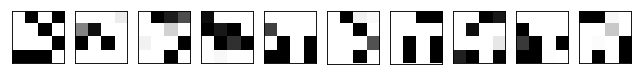

Model Adam Discr+dp:


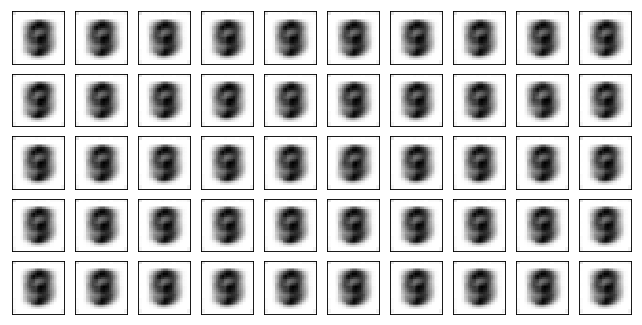

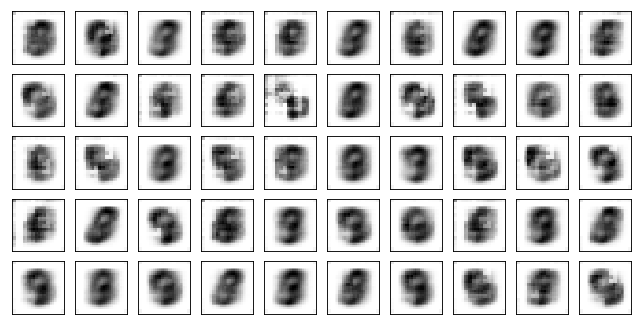

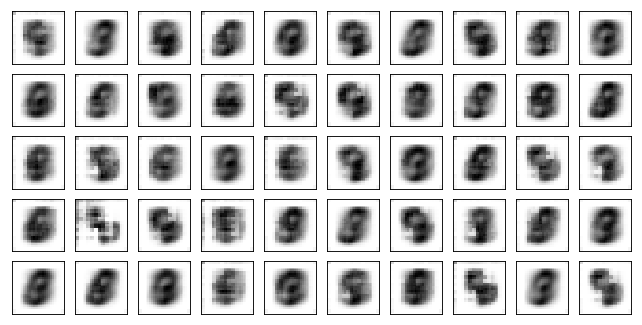

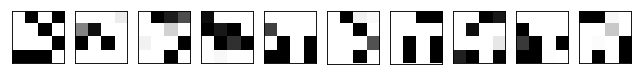

Model Adam Discr+bn+dp:


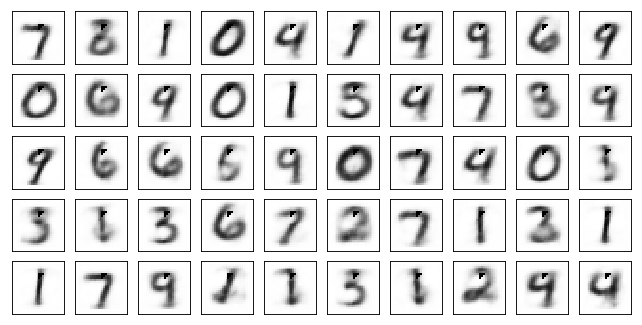

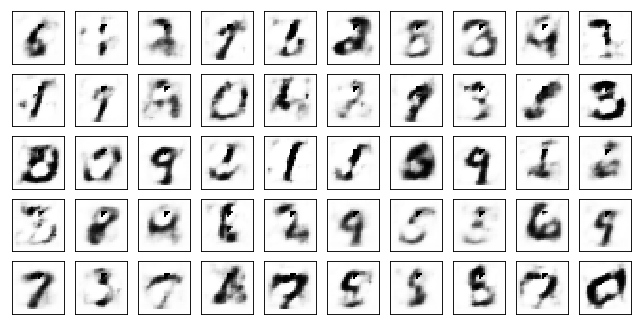

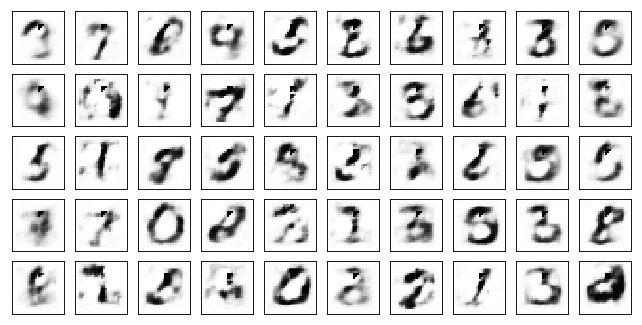

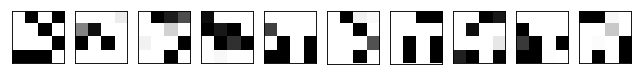

Test losses: 
Adam Discr+bn: 0.79731774 / 4.18598795 / 0.00856988 
Adam Discr+dp: 1.33982575 / 3.68468809 / 0.02717620 
Adam Discr+bn+dp: 0.82979172 / 4.84866238 / 0.00603589 

Train Epoch: 76 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0270 D:0.0007 Adam Discr+dp: AE:1.0036 D:0.0011 Adam Discr+bn+dp: AE:1.1493 D:0.0002
Train Epoch: 76 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0683 D:0.0004 Adam Discr+dp: AE:1.0211 D:0.0007 Adam Discr+bn+dp: AE:1.1152 D:0.0002
Train Epoch: 76 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0416 D:0.0005 Adam Discr+dp: AE:0.9394 D:0.0439 Adam Discr+bn+dp: AE:1.0635 D:0.0002
Test losses: 
Adam Discr+bn: 0.77433348 / 4.57118511 / 0.00509169 
Adam Discr+dp: 1.32044828 / 3.73784924 / 0.01849772 
Adam Discr+bn+dp: 0.82072663 / 4.96283913 / 0.00613024 

Train Epoch: 77 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0423 D:0.0003 Adam Discr+dp: AE:1.0204 D:0.0037 Adam Discr+bn+dp: AE:1.1489 D:0.0002
Train Epoch: 77 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

Train Epoch: 89 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0641 D:0.0002 Adam Discr+dp: AE:0.9636 D:0.0013 Adam Discr+bn+dp: AE:1.1873 D:0.0157
Train Epoch: 89 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0599 D:0.0004 Adam Discr+dp: AE:1.0243 D:0.0030 Adam Discr+bn+dp: AE:1.0274 D:0.0007
Test losses: 
Adam Discr+bn: 0.76700944 / 4.56513548 / 0.00103364 
Adam Discr+dp: 1.33119488 / 3.89326739 / 0.02360431 
Adam Discr+bn+dp: 0.80632544 / 4.80644941 / 0.00338088 

Train Epoch: 90 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0604 D:0.0003 Adam Discr+dp: AE:1.0398 D:0.0005 Adam Discr+bn+dp: AE:1.0415 D:0.0009
Train Epoch: 90 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0550 D:0.0004 Adam Discr+dp: AE:0.9925 D:0.0090 Adam Discr+bn+dp: AE:1.0341 D:0.0003
Train Epoch: 90 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0067 D:0.0004 Adam Discr+dp: AE:1.0523 D:0.0207 Adam Discr+bn+dp: AE:1.1374 D:0.0001
Test losses: 
Adam Discr+bn: 0.78352880 / 4.56270647 / 0.00441521 
Adam Discr+dp: 1.29

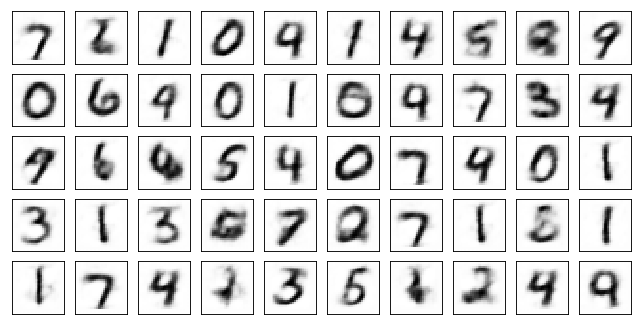

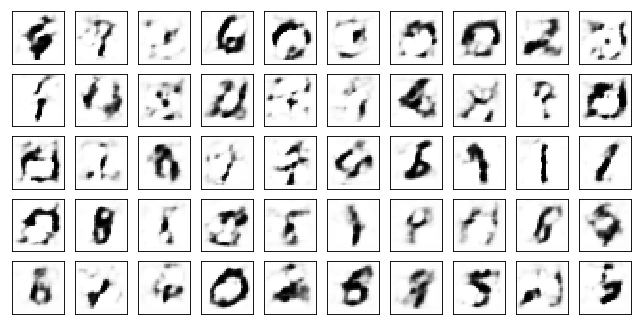

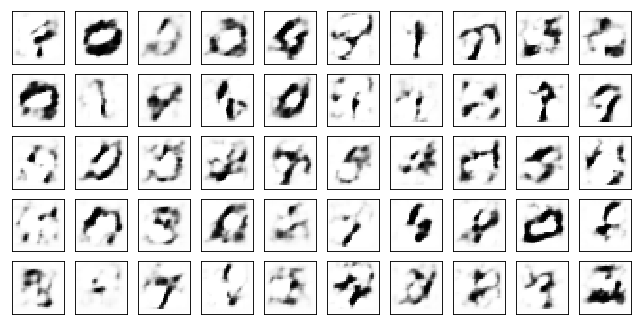

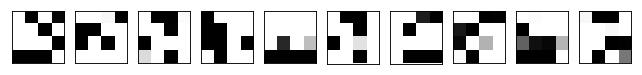

Model Adam Discr+dp:


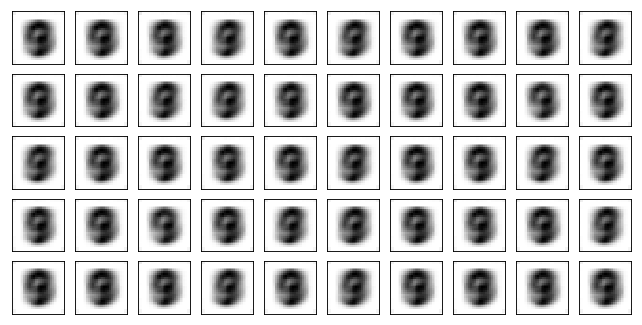

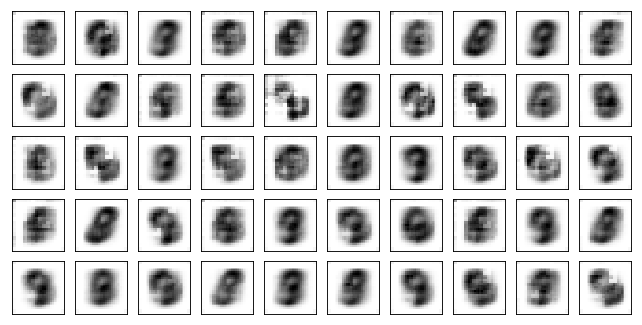

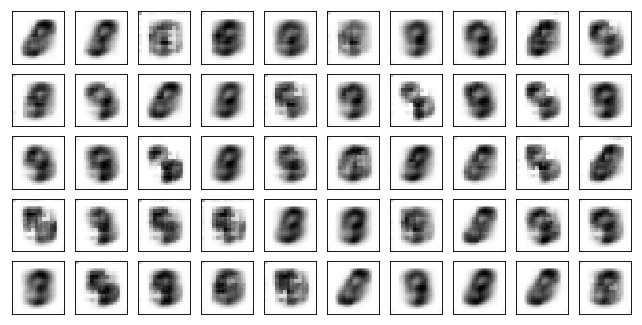

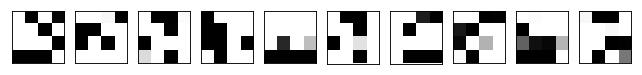

Model Adam Discr+bn+dp:


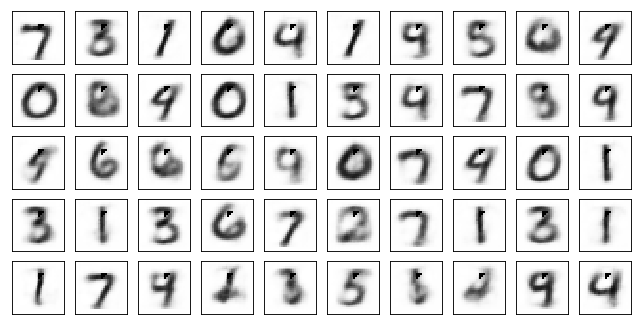

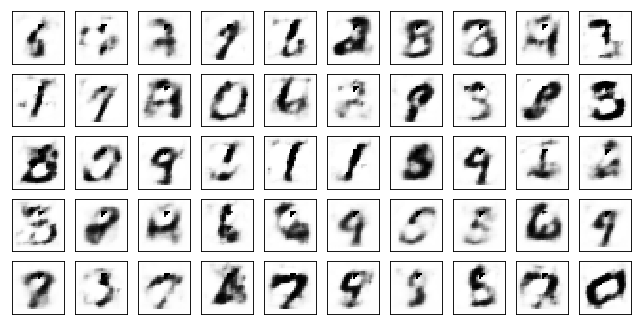

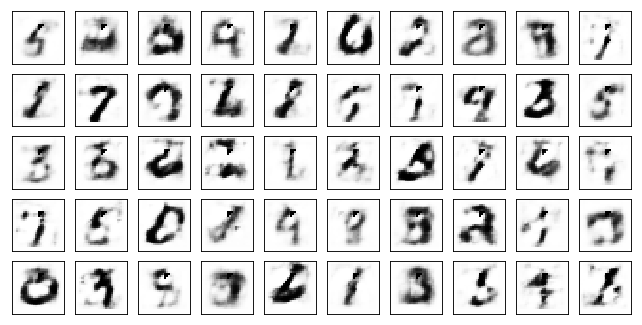

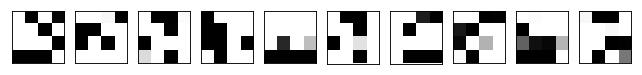

Test losses: 
Adam Discr+bn: 0.74582082 / 4.52121210 / 0.00547640 
Adam Discr+dp: 1.31932640 / 3.81300306 / 0.02361910 
Adam Discr+bn+dp: 0.80978465 / 4.87769127 / 0.00284140 

Train Epoch: 101 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0337 D:0.0017 Adam Discr+dp: AE:1.0394 D:0.0005 Adam Discr+bn+dp: AE:1.0856 D:0.0013
Train Epoch: 101 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9873 D:0.0061 Adam Discr+dp: AE:1.0476 D:0.0009 Adam Discr+bn+dp: AE:1.2005 D:0.0001
Train Epoch: 101 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0374 D:0.0009 Adam Discr+dp: AE:1.0734 D:0.0011 Adam Discr+bn+dp: AE:1.1299 D:0.0002
Test losses: 
Adam Discr+bn: 0.71945083 / 4.64649630 / 0.00492406 
Adam Discr+dp: 1.29416180 / 3.95118976 / 0.02067149 
Adam Discr+bn+dp: 0.80862081 / 5.13364983 / 0.00277571 

Train Epoch: 102 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0650 D:0.0032 Adam Discr+dp: AE:1.0221 D:0.0654 Adam Discr+bn+dp: AE:1.1888 D:0.0005
Train Epoch: 102 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 114 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9622 D:0.0002 Adam Discr+dp: AE:0.9831 D:0.0029 Adam Discr+bn+dp: AE:1.1556 D:0.0001
Train Epoch: 114 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0923 D:0.0005 Adam Discr+dp: AE:1.0910 D:0.0010 Adam Discr+bn+dp: AE:1.1229 D:0.0001
Test losses: 
Adam Discr+bn: 0.70090199 / 4.81294107 / 0.00628664 
Adam Discr+dp: 1.28438842 / 4.29831600 / 0.02015570 
Adam Discr+bn+dp: 0.80245507 / 5.15905428 / 0.00402609 

Train Epoch: 115 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0647 D:0.0004 Adam Discr+dp: AE:1.0674 D:0.0016 Adam Discr+bn+dp: AE:1.1893 D:0.0002
Train Epoch: 115 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1152 D:0.0001 Adam Discr+dp: AE:1.0541 D:0.0010 Adam Discr+bn+dp: AE:1.1692 D:0.0001
Train Epoch: 115 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9965 D:0.0002 Adam Discr+dp: AE:1.0230 D:0.0011 Adam Discr+bn+dp: AE:1.1693 D:0.0004
Test losses: 
Adam Discr+bn: 0.69188881 / 4.61807966 / 0.00493049 
Adam Discr+dp:

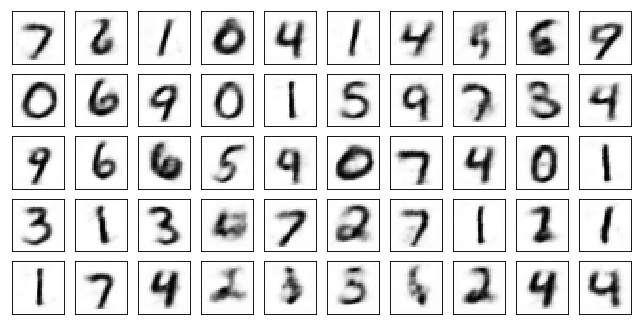

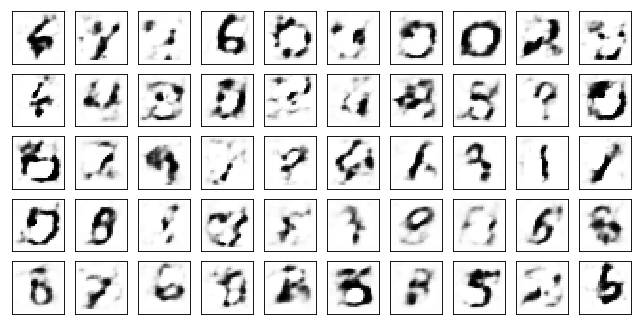

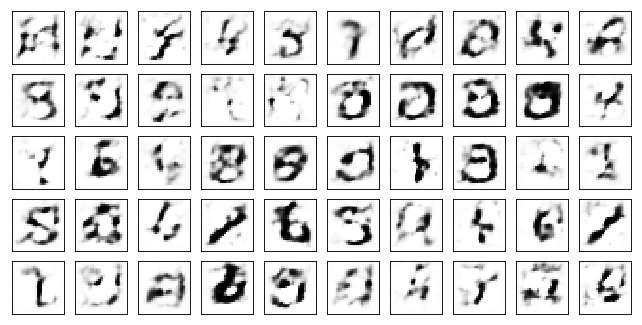

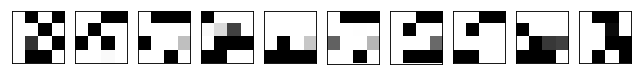

Model Adam Discr+dp:


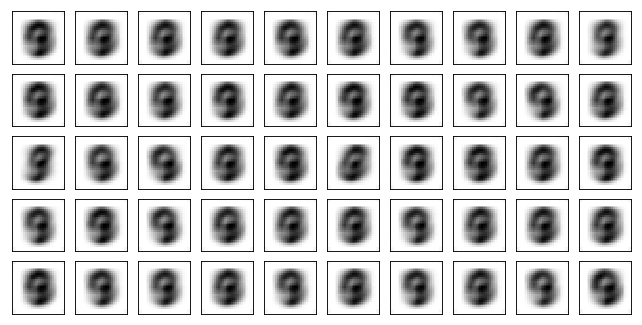

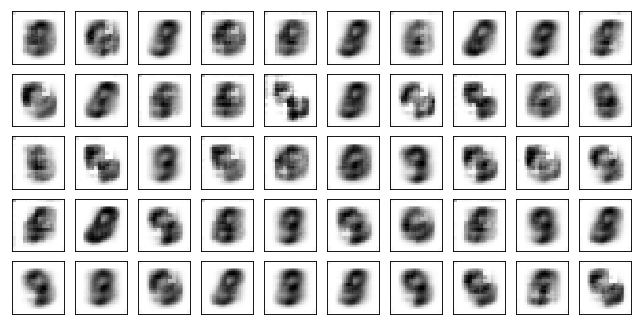

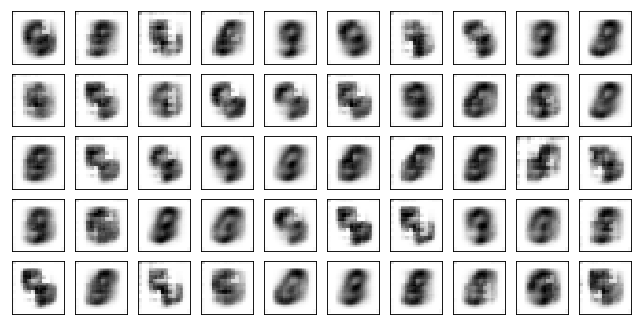

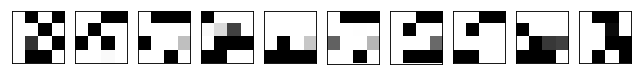

Model Adam Discr+bn+dp:


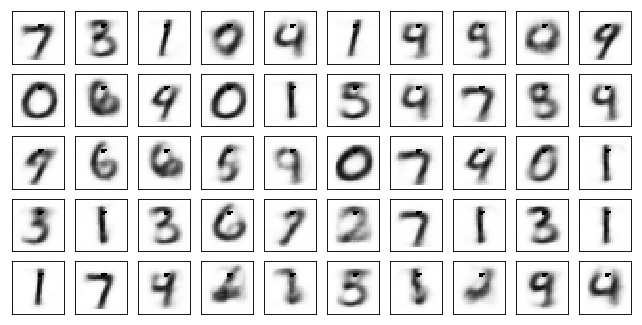

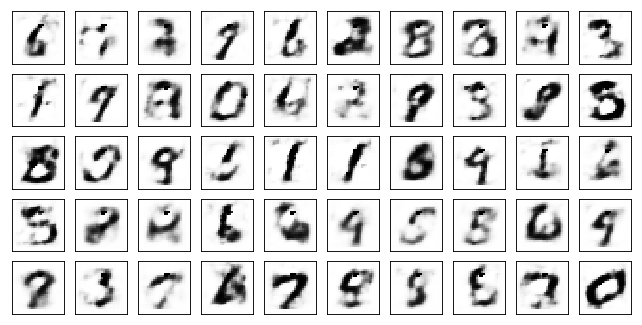

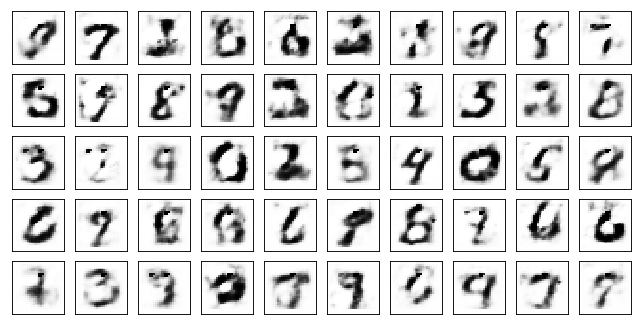

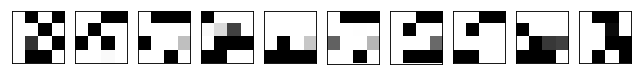

Test losses: 
Adam Discr+bn: 0.68064237 / 4.92128944 / 0.00244500 
Adam Discr+dp: 1.29150748 / 4.12318754 / 0.01774337 
Adam Discr+bn+dp: 0.77603620 / 4.95162439 / 0.00252743 

Train Epoch: 126 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0912 D:0.0001 Adam Discr+dp: AE:0.9931 D:0.0014 Adam Discr+bn+dp: AE:1.0677 D:0.0001
Train Epoch: 126 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0978 D:0.0002 Adam Discr+dp: AE:1.0667 D:0.0006 Adam Discr+bn+dp: AE:1.1087 D:0.0002
Train Epoch: 126 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0510 D:0.0003 Adam Discr+dp: AE:1.0602 D:0.0010 Adam Discr+bn+dp: AE:1.1396 D:0.0004
Test losses: 
Adam Discr+bn: 0.68630677 / 4.90630627 / 0.00476785 
Adam Discr+dp: 1.26931107 / 4.11683416 / 0.01914565 
Adam Discr+bn+dp: 0.77643508 / 5.08444118 / 0.00243545 

Train Epoch: 127 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1229 D:0.0005 Adam Discr+dp: AE:1.0455 D:0.0010 Adam Discr+bn+dp: AE:1.1290 D:0.0004
Train Epoch: 127 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 139 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0241 D:0.0003 Adam Discr+dp: AE:0.9655 D:0.0011 Adam Discr+bn+dp: AE:1.1070 D:0.0003
Train Epoch: 139 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1234 D:0.0162 Adam Discr+dp: AE:1.0459 D:0.0007 Adam Discr+bn+dp: AE:1.1707 D:0.0021
Test losses: 
Adam Discr+bn: 0.70164025 / 5.12334776 / 0.00371259 
Adam Discr+dp: 1.27687061 / 4.39928102 / 0.01633628 
Adam Discr+bn+dp: 0.76423109 / 5.36764050 / 0.00306187 

Train Epoch: 140 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0962 D:0.0001 Adam Discr+dp: AE:1.0840 D:0.0029 Adam Discr+bn+dp: AE:1.1538 D:0.0001
Train Epoch: 140 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0570 D:0.0013 Adam Discr+dp: AE:1.0054 D:0.0003 Adam Discr+bn+dp: AE:1.1337 D:0.0002
Train Epoch: 140 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0749 D:0.0003 Adam Discr+dp: AE:1.0783 D:0.0254 Adam Discr+bn+dp: AE:1.1335 D:0.0001
Test losses: 
Adam Discr+bn: 0.67063057 / 5.04237509 / 0.00285810 
Adam Discr+dp:

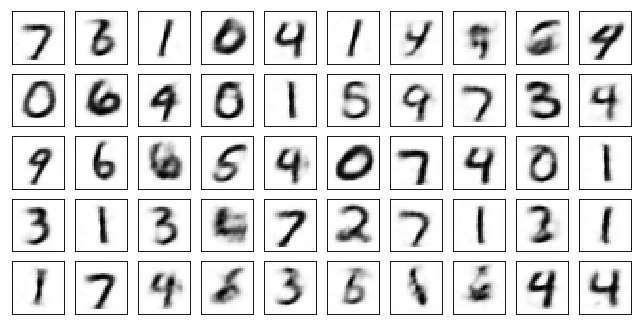

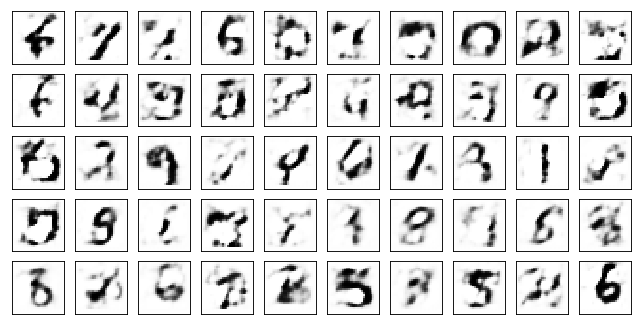

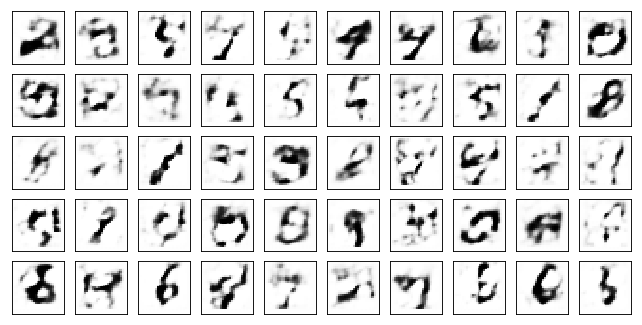

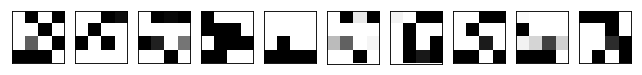

Model Adam Discr+dp:


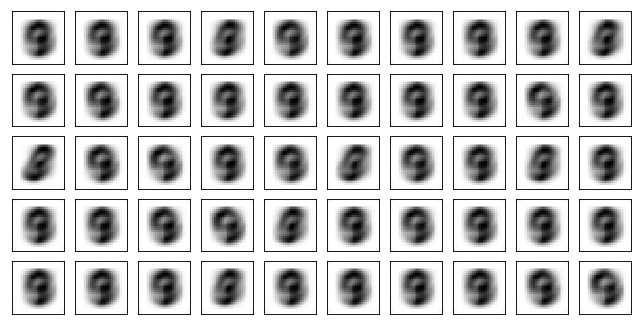

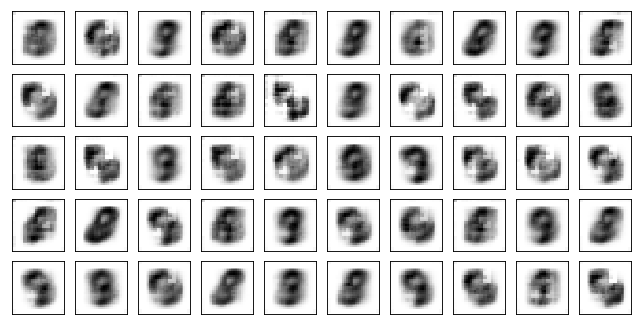

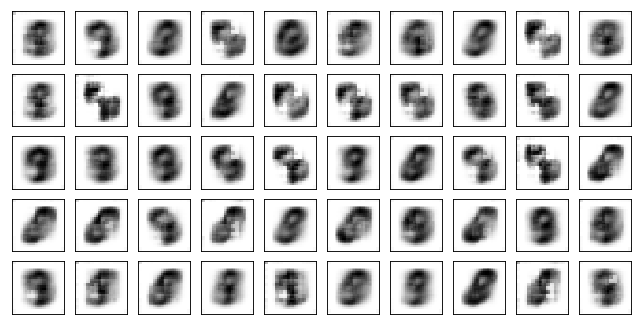

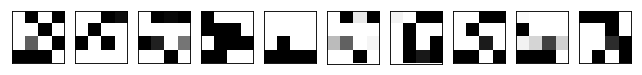

Model Adam Discr+bn+dp:


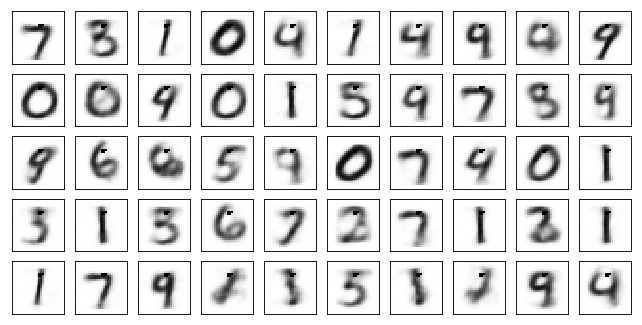

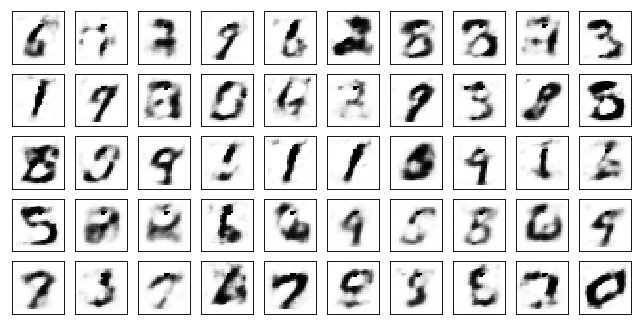

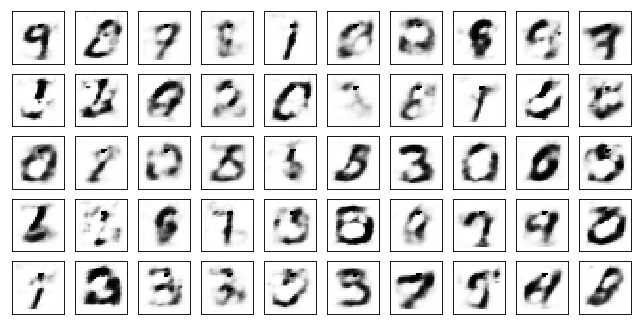

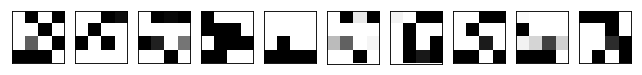

Test losses: 
Adam Discr+bn: 0.67671430 / 4.91587925 / 0.00415084 
Adam Discr+dp: 1.27344370 / 4.13948536 / 0.00947058 
Adam Discr+bn+dp: 0.77000320 / 5.48521233 / 0.00511032 

Train Epoch: 151 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0802 D:0.0002 Adam Discr+dp: AE:1.0284 D:0.0009 Adam Discr+bn+dp: AE:1.2643 D:0.0001
Train Epoch: 151 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0278 D:0.0001 Adam Discr+dp: AE:1.0466 D:0.0007 Adam Discr+bn+dp: AE:1.2104 D:0.0001
Train Epoch: 151 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1541 D:0.0001 Adam Discr+dp: AE:1.0185 D:0.0009 Adam Discr+bn+dp: AE:1.1622 D:0.0004
Test losses: 
Adam Discr+bn: 0.67411923 / 5.30935574 / 0.00500801 
Adam Discr+dp: 1.27775216 / 4.14585924 / 0.01506159 
Adam Discr+bn+dp: 0.76966691 / 5.31324816 / 0.00273273 

Train Epoch: 152 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1801 D:0.0000 Adam Discr+dp: AE:1.0937 D:0.0009 Adam Discr+bn+dp: AE:1.1442 D:0.0001
Train Epoch: 152 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 164 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1364 D:0.0001 Adam Discr+dp: AE:1.0285 D:0.0008 Adam Discr+bn+dp: AE:1.1005 D:0.0004
Train Epoch: 164 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1093 D:0.0002 Adam Discr+dp: AE:1.0990 D:0.0008 Adam Discr+bn+dp: AE:1.1999 D:0.0001
Test losses: 
Adam Discr+bn: 0.68874753 / 5.12747049 / 0.00257215 
Adam Discr+dp: 1.26366889 / 4.46662903 / 0.01606339 
Adam Discr+bn+dp: 0.76584446 / 5.38567924 / 0.00171621 

Train Epoch: 165 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0838 D:0.0002 Adam Discr+dp: AE:1.0961 D:0.0049 Adam Discr+bn+dp: AE:1.2278 D:0.0001
Train Epoch: 165 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0598 D:0.0003 Adam Discr+dp: AE:1.0267 D:0.0013 Adam Discr+bn+dp: AE:1.2375 D:0.0002
Train Epoch: 165 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1683 D:0.0192 Adam Discr+dp: AE:1.0464 D:0.0016 Adam Discr+bn+dp: AE:1.1442 D:0.0001
Test losses: 
Adam Discr+bn: 0.68627870 / 5.32388783 / 0.00315960 
Adam Discr+dp:

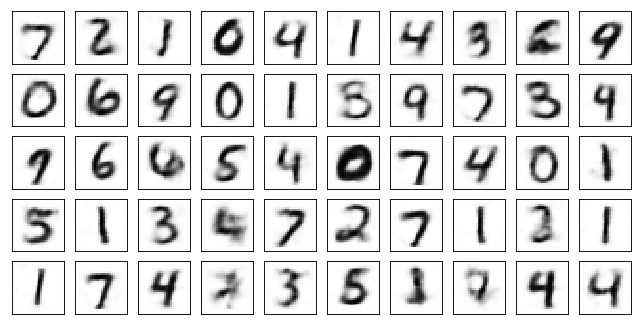

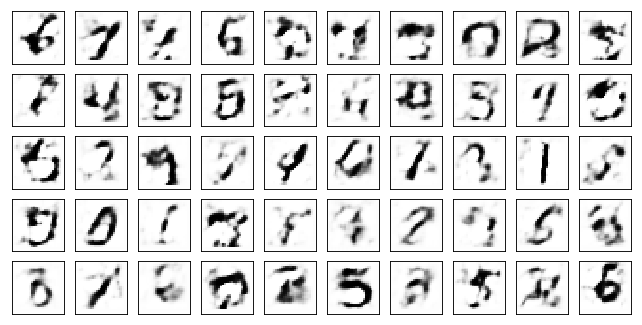

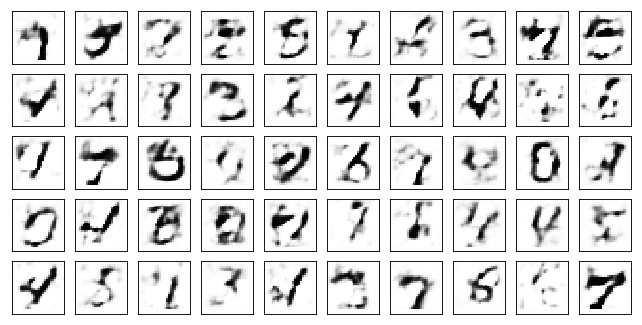

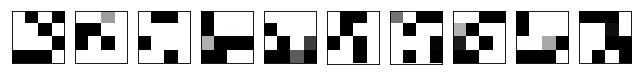

Model Adam Discr+dp:


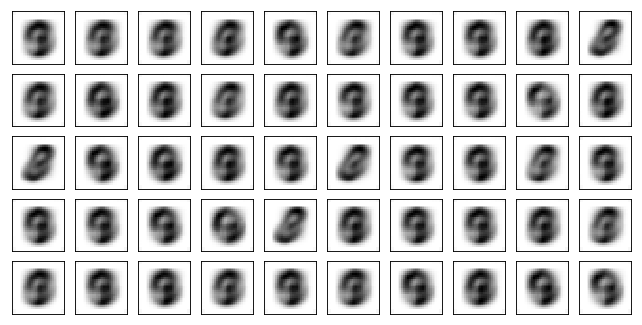

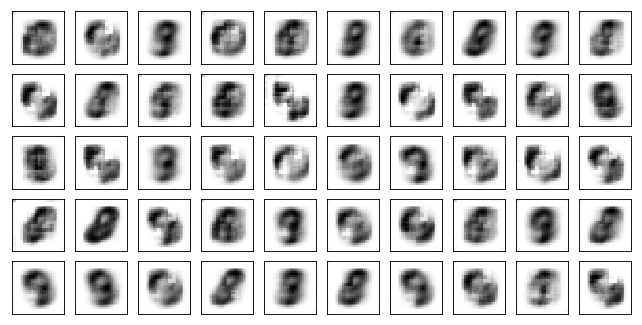

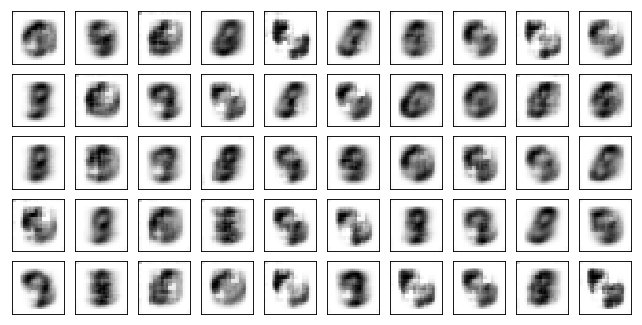

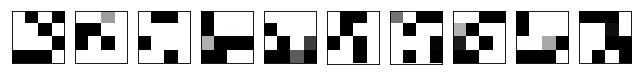

Model Adam Discr+bn+dp:


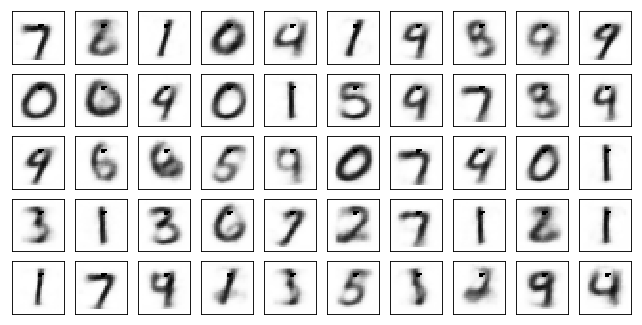

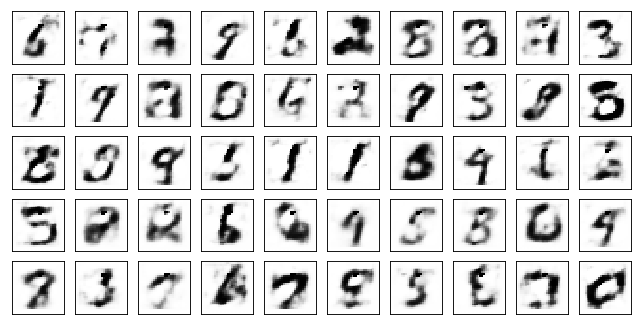

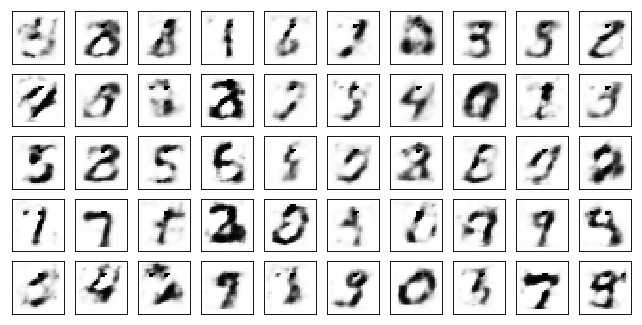

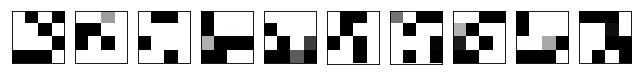

Test losses: 
Adam Discr+bn: 0.67713612 / 5.29901600 / 0.00200963 
Adam Discr+dp: 1.26645315 / 4.16994238 / 0.00945869 
Adam Discr+bn+dp: 0.76046669 / 5.33160591 / 0.00372386 

Train Epoch: 176 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1272 D:0.0001 Adam Discr+dp: AE:1.0219 D:0.0005 Adam Discr+bn+dp: AE:1.1376 D:0.0014
Train Epoch: 176 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1404 D:0.0002 Adam Discr+dp: AE:1.0319 D:0.0005 Adam Discr+bn+dp: AE:1.1733 D:0.0001
Train Epoch: 176 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0966 D:0.0001 Adam Discr+dp: AE:1.0717 D:0.0006 Adam Discr+bn+dp: AE:1.2466 D:0.0001
Test losses: 
Adam Discr+bn: 0.67210186 / 5.20358181 / 0.00258840 
Adam Discr+dp: 1.27634978 / 4.41140079 / 0.01007501 
Adam Discr+bn+dp: 0.76239508 / 5.57094002 / 0.00419707 

Train Epoch: 177 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1079 D:0.0007 Adam Discr+dp: AE:1.0754 D:0.0006 Adam Discr+bn+dp: AE:1.2892 D:0.0000
Train Epoch: 177 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 189 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1632 D:0.0002 Adam Discr+dp: AE:1.0755 D:0.0005 Adam Discr+bn+dp: AE:1.1828 D:0.0002
Train Epoch: 189 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1330 D:0.0001 Adam Discr+dp: AE:1.0754 D:0.0004 Adam Discr+bn+dp: AE:1.1558 D:0.0000
Test losses: 
Adam Discr+bn: 0.66775656 / 5.29060030 / 0.00363357 
Adam Discr+dp: 1.25791657 / 4.26931572 / 0.01238971 
Adam Discr+bn+dp: 0.72982711 / 5.40416861 / 0.00176568 

Train Epoch: 190 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1650 D:0.0002 Adam Discr+dp: AE:1.1068 D:0.0004 Adam Discr+bn+dp: AE:1.1839 D:0.0001
Train Epoch: 190 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1021 D:0.0002 Adam Discr+dp: AE:1.0594 D:0.0003 Adam Discr+bn+dp: AE:1.1743 D:0.0003
Train Epoch: 190 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1459 D:0.0001 Adam Discr+dp: AE:1.0518 D:0.0006 Adam Discr+bn+dp: AE:1.0581 D:0.0012
Test losses: 
Adam Discr+bn: 0.68021458 / 5.35888052 / 0.00236020 
Adam Discr+dp:

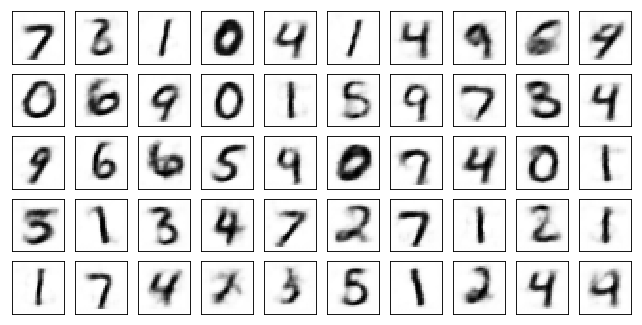

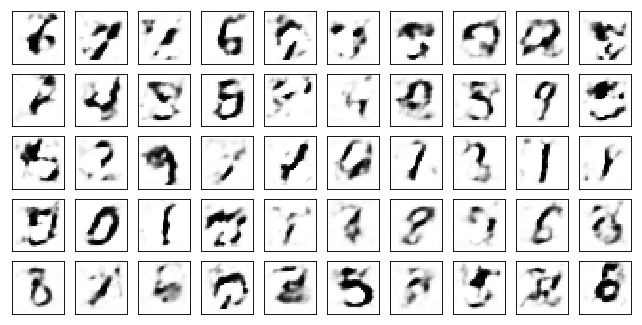

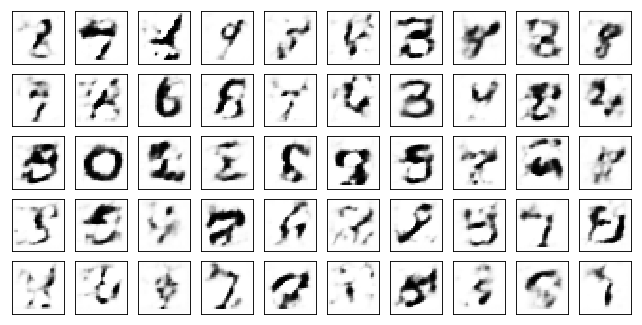

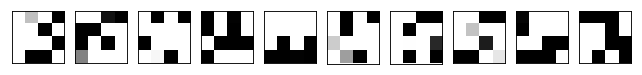

Model Adam Discr+dp:


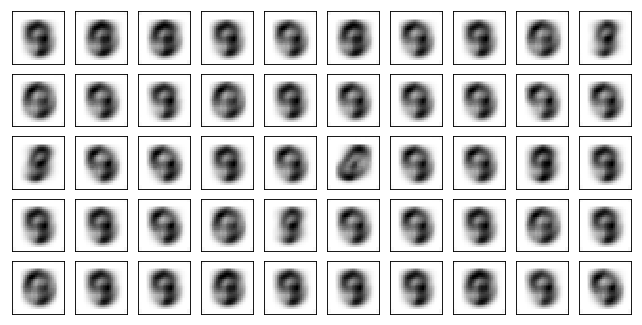

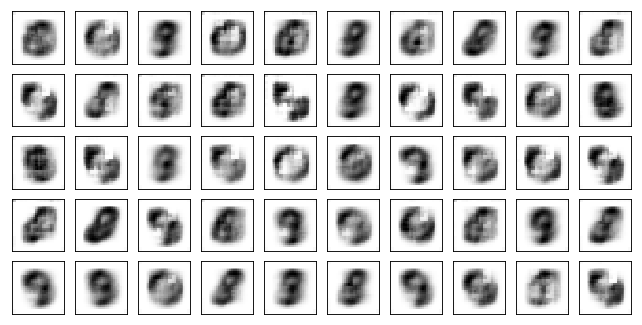

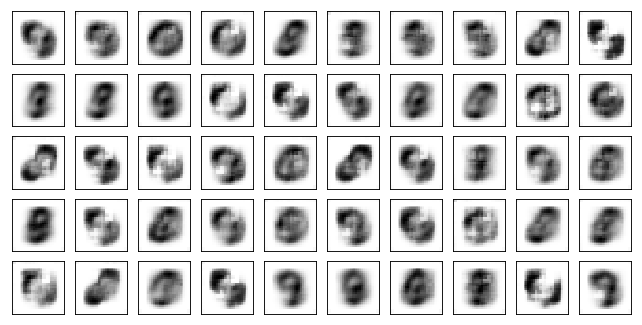

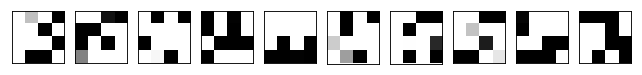

Model Adam Discr+bn+dp:


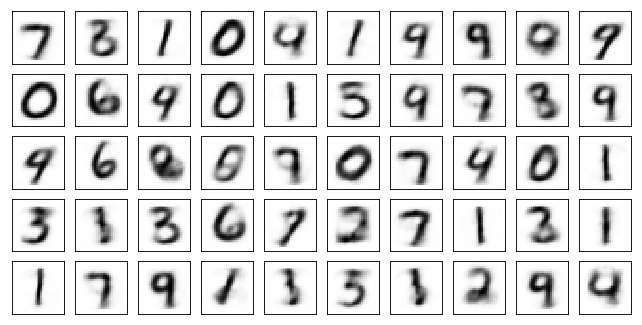

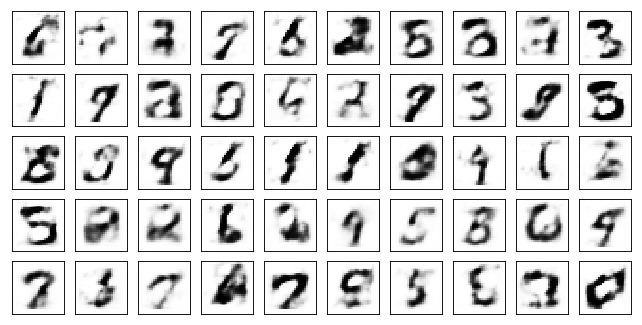

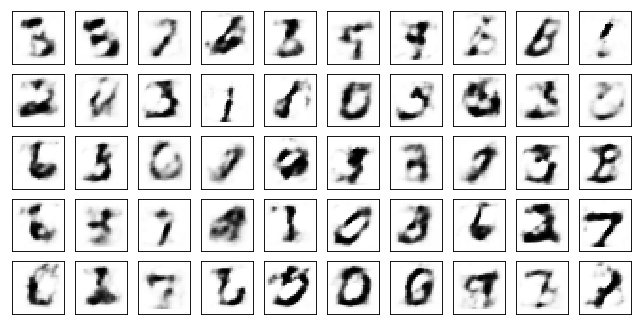

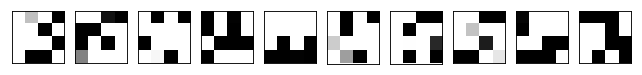

Test losses: 
Adam Discr+bn: 0.65385598 / 5.19159031 / 0.00367484 
Adam Discr+dp: 1.25213754 / 4.44308043 / 0.00895533 
Adam Discr+bn+dp: 0.72081870 / 5.28913736 / 0.00207387 

Train Epoch: 201 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1296 D:0.0016 Adam Discr+dp: AE:1.0900 D:0.0002 Adam Discr+bn+dp: AE:1.1751 D:0.0002
Train Epoch: 201 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1477 D:0.0001 Adam Discr+dp: AE:1.0648 D:0.0011 Adam Discr+bn+dp: AE:1.1178 D:0.0002
Train Epoch: 201 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1138 D:0.0001 Adam Discr+dp: AE:1.0245 D:0.0005 Adam Discr+bn+dp: AE:1.1747 D:0.0002
Test losses: 
Adam Discr+bn: 0.66340351 / 5.31498289 / 0.00371923 
Adam Discr+dp: 1.23362136 / 4.50776958 / 0.00824774 
Adam Discr+bn+dp: 0.71256614 / 5.15795326 / 0.00139232 

Train Epoch: 202 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1807 D:0.0002 Adam Discr+dp: AE:1.1325 D:0.0798 Adam Discr+bn+dp: AE:1.1098 D:0.0002
Train Epoch: 202 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 214 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0357 D:0.0004 Adam Discr+dp: AE:1.0461 D:0.0005 Adam Discr+bn+dp: AE:1.2324 D:0.0001
Train Epoch: 214 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1289 D:0.0010 Adam Discr+dp: AE:1.0962 D:0.0015 Adam Discr+bn+dp: AE:1.1627 D:0.0001
Test losses: 
Adam Discr+bn: 0.68073356 / 5.40764284 / 0.00308098 
Adam Discr+dp: 1.26857293 / 4.64455128 / 0.00770954 
Adam Discr+bn+dp: 0.71637535 / 5.43720388 / 0.00144235 

Train Epoch: 215 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1753 D:0.0001 Adam Discr+dp: AE:1.0893 D:0.0006 Adam Discr+bn+dp: AE:1.2216 D:0.0001
Train Epoch: 215 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0620 D:0.0002 Adam Discr+dp: AE:1.0678 D:0.0004 Adam Discr+bn+dp: AE:1.2099 D:0.0001
Train Epoch: 215 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1218 D:0.0001 Adam Discr+dp: AE:1.1569 D:0.0001 Adam Discr+bn+dp: AE:1.2313 D:0.0001
Test losses: 
Adam Discr+bn: 0.66903031 / 5.39287472 / 0.00317048 
Adam Discr+dp:

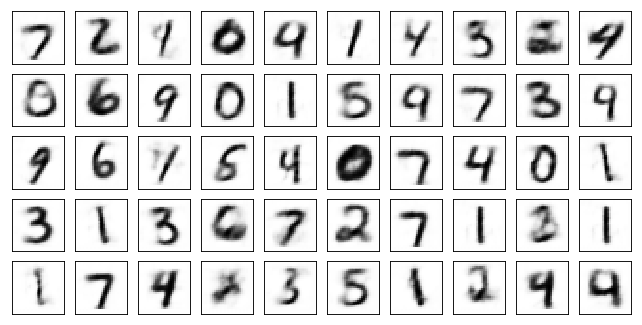

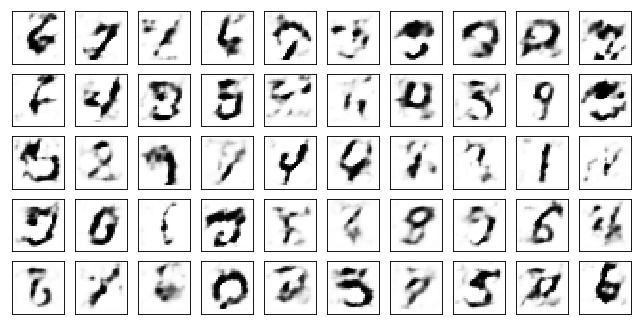

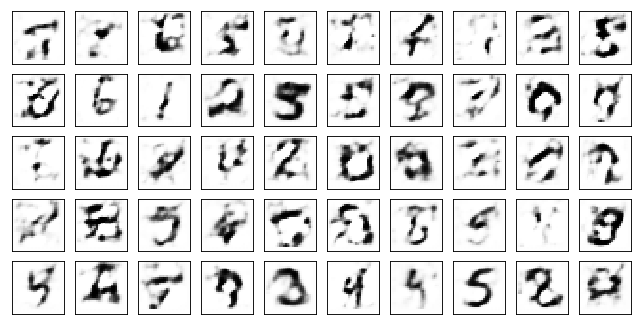

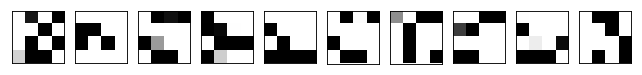

Model Adam Discr+dp:


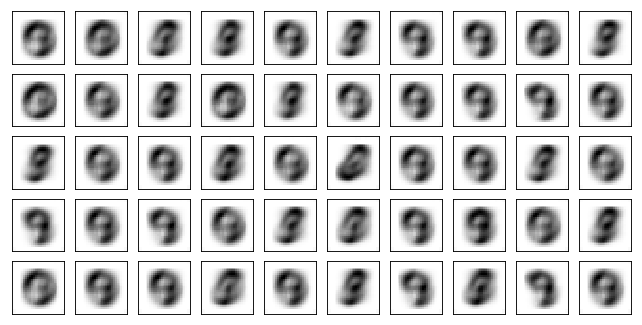

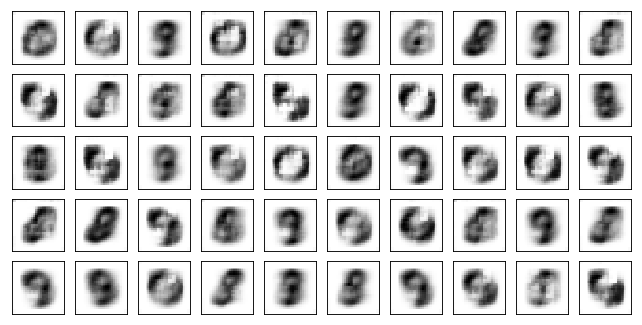

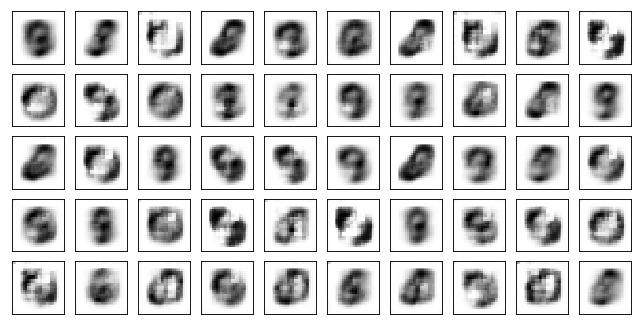

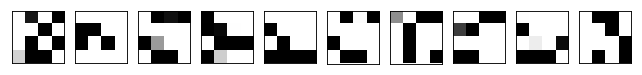

Model Adam Discr+bn+dp:


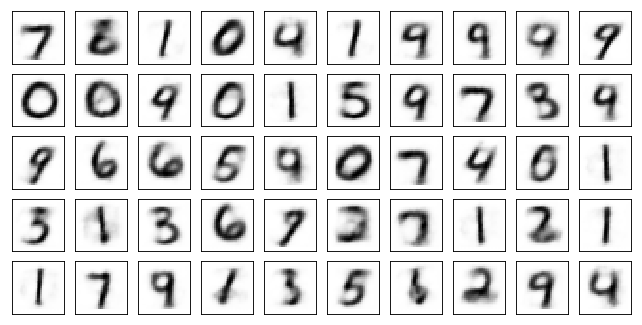

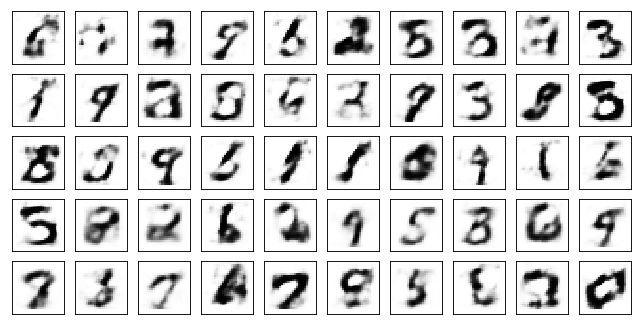

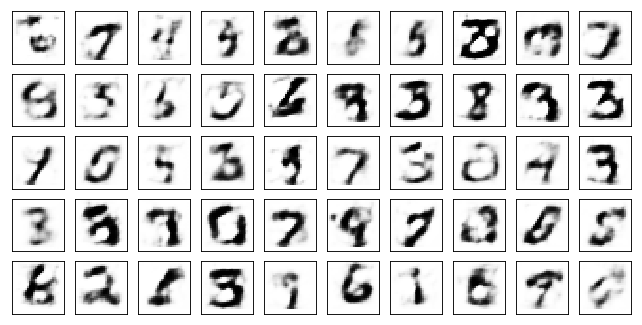

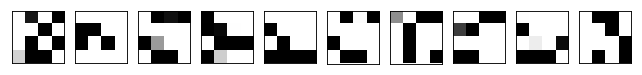

Test losses: 
Adam Discr+bn: 0.66182584 / 5.45354176 / 0.00215473 
Adam Discr+dp: 1.21556389 / 4.50186920 / 0.00834275 
Adam Discr+bn+dp: 0.72085255 / 5.65638351 / 0.00262438 

Train Epoch: 226 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1444 D:0.0001 Adam Discr+dp: AE:1.0992 D:0.0003 Adam Discr+bn+dp: AE:1.2287 D:0.0001
Train Epoch: 226 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1196 D:0.0001 Adam Discr+dp: AE:1.0544 D:0.0002 Adam Discr+bn+dp: AE:1.1137 D:0.0001
Train Epoch: 226 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1599 D:0.0001 Adam Discr+dp: AE:1.1278 D:0.0005 Adam Discr+bn+dp: AE:1.2303 D:0.0001
Test losses: 
Adam Discr+bn: 0.66189492 / 5.33873749 / 0.00345138 
Adam Discr+dp: 1.22326326 / 4.60263014 / 0.00795741 
Adam Discr+bn+dp: 0.72188210 / 5.55344391 / 0.00345981 

Train Epoch: 227 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1279 D:0.0001 Adam Discr+dp: AE:1.1221 D:0.0003 Adam Discr+bn+dp: AE:1.2090 D:0.0001
Train Epoch: 227 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 239 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0894 D:0.0001 Adam Discr+dp: AE:1.1078 D:0.0010 Adam Discr+bn+dp: AE:1.1429 D:0.0001
Train Epoch: 239 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1486 D:0.0001 Adam Discr+dp: AE:1.1227 D:0.0002 Adam Discr+bn+dp: AE:1.2249 D:0.0001
Test losses: 
Adam Discr+bn: 0.65835446 / 5.41553450 / 0.00255137 
Adam Discr+dp: 1.23988283 / 4.65963078 / 0.00450160 
Adam Discr+bn+dp: 0.70608711 / 5.54565001 / 0.00175883 

Train Epoch: 240 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1459 D:0.0001 Adam Discr+dp: AE:1.0867 D:0.0003 Adam Discr+bn+dp: AE:1.2195 D:0.0001
Train Epoch: 240 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1057 D:0.0002 Adam Discr+dp: AE:1.0998 D:0.0003 Adam Discr+bn+dp: AE:1.1595 D:0.0001
Train Epoch: 240 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1344 D:0.0003 Adam Discr+dp: AE:1.1486 D:0.0355 Adam Discr+bn+dp: AE:1.2671 D:0.0002
Test losses: 
Adam Discr+bn: 0.67288107 / 5.29450655 / 0.00262317 
Adam Discr+dp:

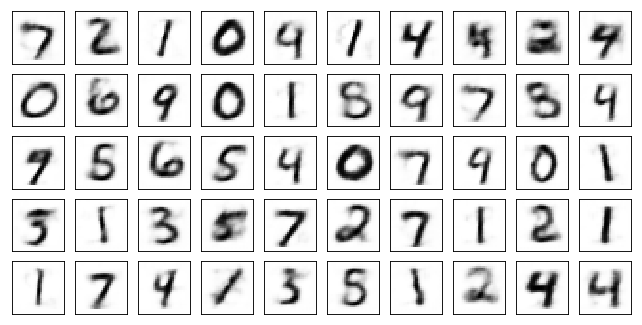

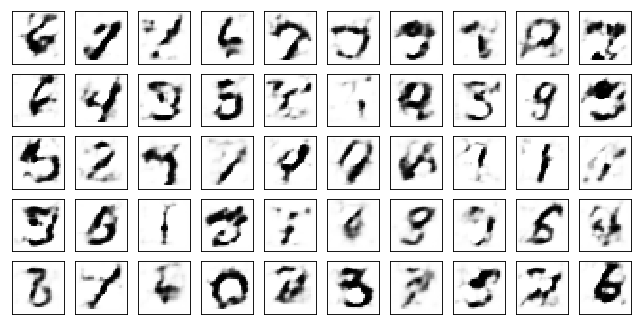

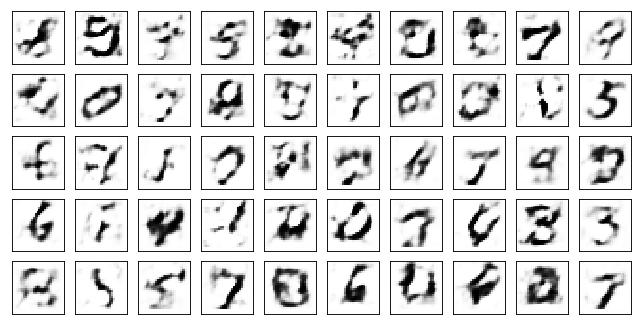

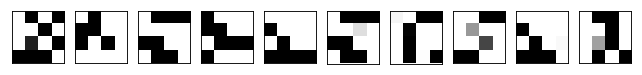

Model Adam Discr+dp:


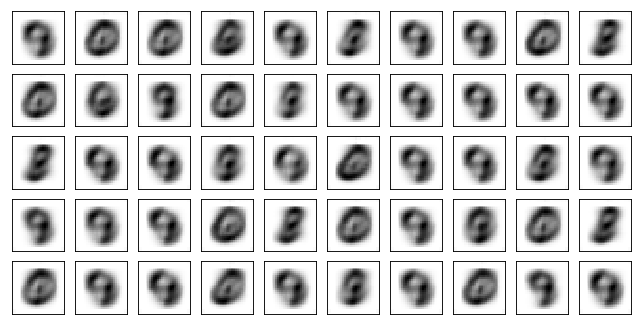

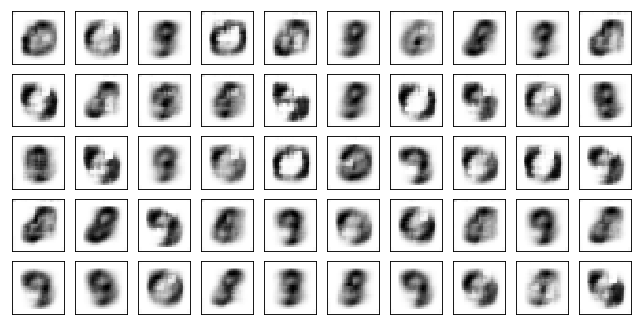

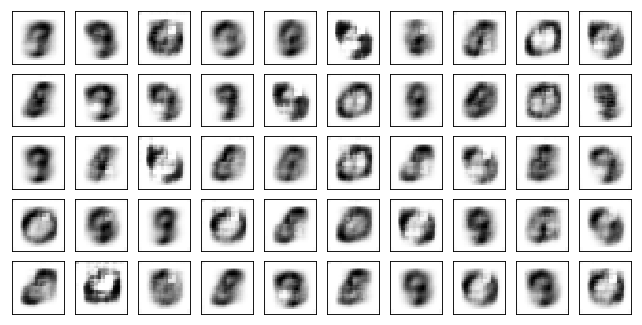

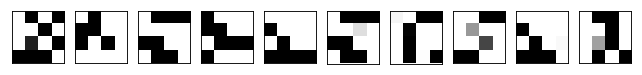

Model Adam Discr+bn+dp:


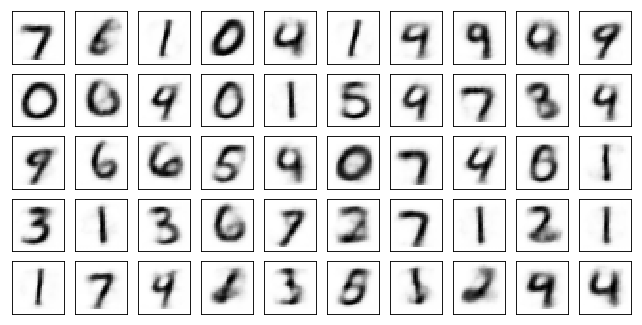

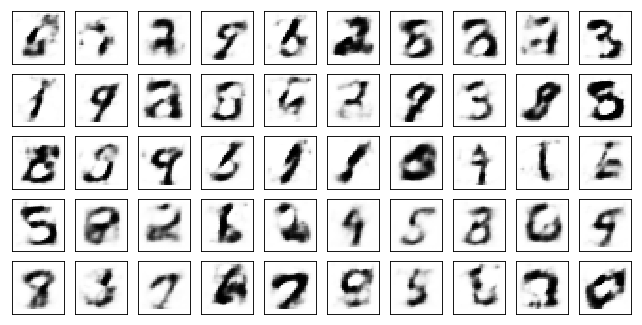

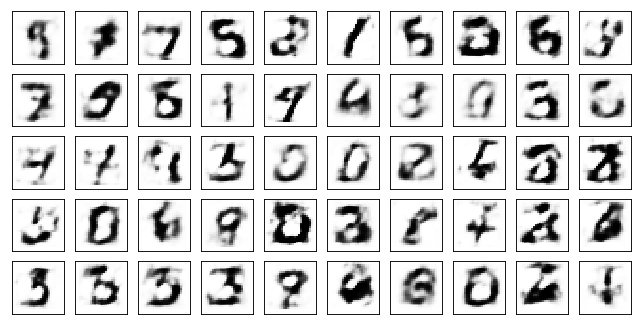

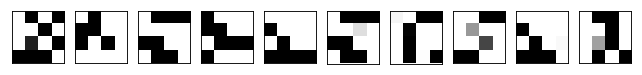

Test losses: 
Adam Discr+bn: 0.68130690 / 5.56958199 / 0.00300113 
Adam Discr+dp: 1.22281992 / 4.39940262 / 0.00597805 
Adam Discr+bn+dp: 0.71736962 / 5.43894148 / 0.00279567 

Train Epoch: 251 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1508 D:0.0001 Adam Discr+dp: AE:1.0141 D:0.0007 Adam Discr+bn+dp: AE:1.1610 D:0.0002
Train Epoch: 251 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1159 D:0.0001 Adam Discr+dp: AE:1.1980 D:0.0002 Adam Discr+bn+dp: AE:1.2085 D:0.0001
Train Epoch: 251 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0441 D:0.0002 Adam Discr+dp: AE:1.1269 D:0.0011 Adam Discr+bn+dp: AE:1.2208 D:0.0001
Test losses: 
Adam Discr+bn: 0.68981665 / 5.09880018 / 0.00151072 
Adam Discr+dp: 1.21235132 / 4.47739887 / 0.00558133 
Adam Discr+bn+dp: 0.71486592 / 5.57234097 / 0.00190936 

Train Epoch: 252 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0850 D:0.0003 Adam Discr+dp: AE:1.1362 D:0.0006 Adam Discr+bn+dp: AE:1.2072 D:0.0001
Train Epoch: 252 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 264 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0591 D:0.0002 Adam Discr+dp: AE:1.0181 D:0.0004 Adam Discr+bn+dp: AE:1.1860 D:0.0002
Train Epoch: 264 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1807 D:0.0000 Adam Discr+dp: AE:1.1490 D:0.0006 Adam Discr+bn+dp: AE:1.1866 D:0.0002
Test losses: 
Adam Discr+bn: 0.67816901 / 5.61134005 / 0.00351424 
Adam Discr+dp: 1.19156075 / 4.76225185 / 0.00574343 
Adam Discr+bn+dp: 0.71354717 / 5.38923168 / 0.00093943 

Train Epoch: 265 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2292 D:0.0001 Adam Discr+dp: AE:1.1180 D:0.0002 Adam Discr+bn+dp: AE:1.1549 D:0.0001
Train Epoch: 265 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1712 D:0.0001 Adam Discr+dp: AE:1.1421 D:0.0003 Adam Discr+bn+dp: AE:1.2067 D:0.0003
Train Epoch: 265 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1078 D:0.0002 Adam Discr+dp: AE:1.0984 D:0.0002 Adam Discr+bn+dp: AE:1.1596 D:0.0004
Test losses: 
Adam Discr+bn: 0.66625154 / 5.26066828 / 0.00080535 
Adam Discr+dp:

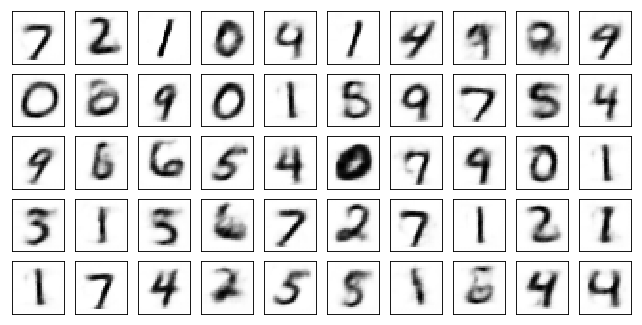

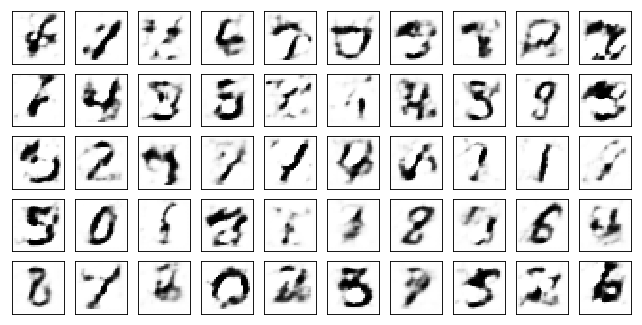

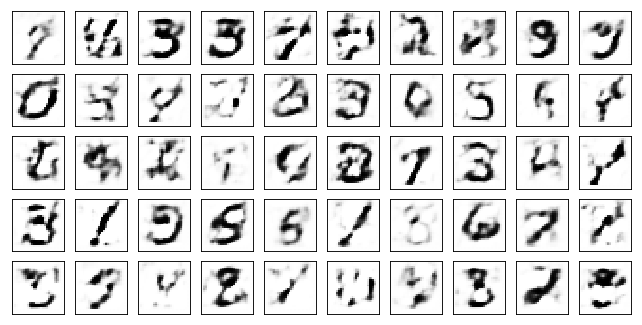

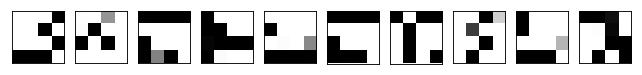

Model Adam Discr+dp:


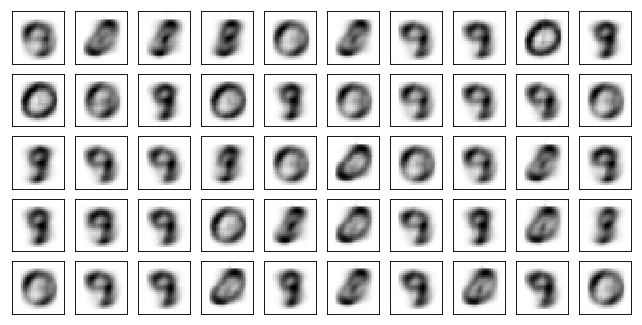

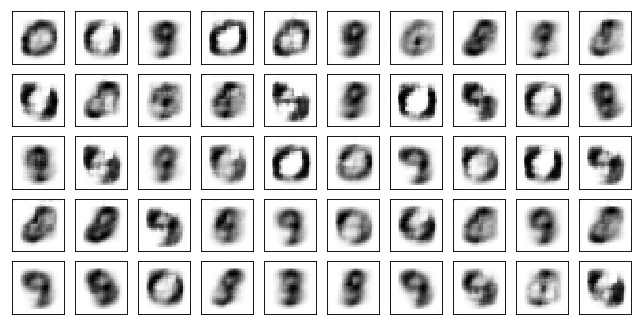

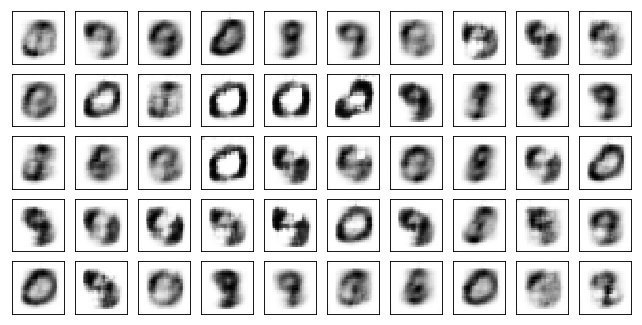

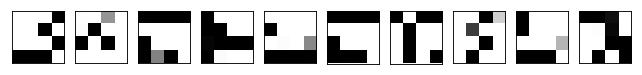

Model Adam Discr+bn+dp:


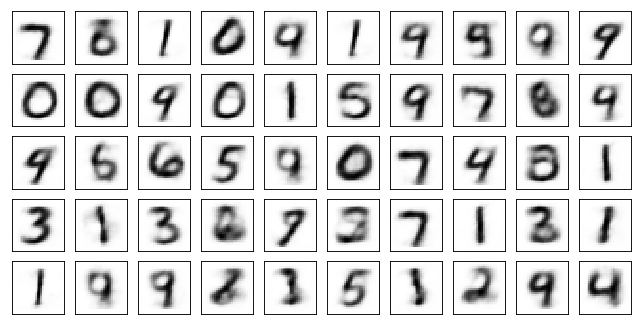

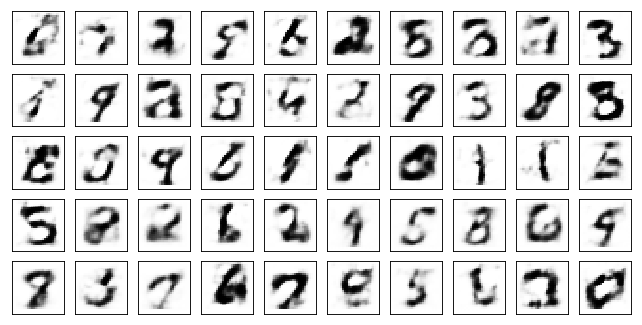

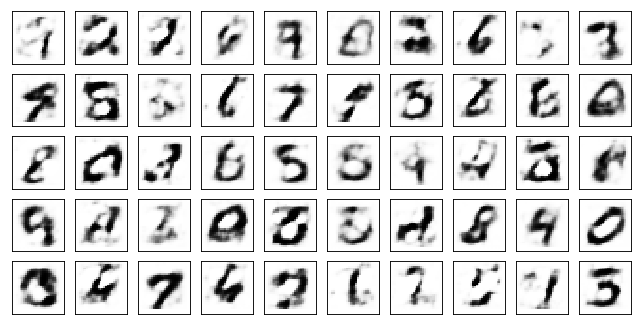

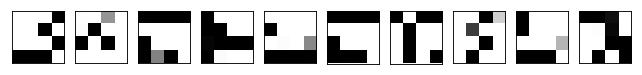

Test losses: 
Adam Discr+bn: 0.69971365 / 5.73352766 / 0.00245453 
Adam Discr+dp: 1.17934883 / 4.74542141 / 0.00558507 
Adam Discr+bn+dp: 0.71471673 / 5.44044924 / 0.00235358 

Train Epoch: 276 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2021 D:0.0000 Adam Discr+dp: AE:1.1758 D:0.0002 Adam Discr+bn+dp: AE:1.1603 D:0.0002
Train Epoch: 276 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1582 D:0.0001 Adam Discr+dp: AE:1.1158 D:0.0005 Adam Discr+bn+dp: AE:1.2103 D:0.0001
Train Epoch: 276 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2026 D:0.0000 Adam Discr+dp: AE:1.1003 D:0.0003 Adam Discr+bn+dp: AE:1.2153 D:0.0001
Test losses: 
Adam Discr+bn: 0.67656684 / 5.58946514 / 0.00233059 
Adam Discr+dp: 1.16773951 / 4.65344810 / 0.00553673 
Adam Discr+bn+dp: 0.71810627 / 5.59528542 / 0.00117495 

Train Epoch: 277 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1999 D:0.0305 Adam Discr+dp: AE:1.1260 D:0.0003 Adam Discr+bn+dp: AE:1.2369 D:0.0001
Train Epoch: 277 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 289 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1545 D:0.0001 Adam Discr+dp: AE:1.0808 D:0.0004 Adam Discr+bn+dp: AE:1.1892 D:0.0002
Train Epoch: 289 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1842 D:0.0000 Adam Discr+dp: AE:1.1581 D:0.0001 Adam Discr+bn+dp: AE:1.2074 D:0.0000
Test losses: 
Adam Discr+bn: 0.67197967 / 5.70118761 / 0.00203496 
Adam Discr+dp: 1.23412156 / 4.77152681 / 0.00579238 
Adam Discr+bn+dp: 0.71526951 / 5.74795437 / 0.00260406 

Train Epoch: 290 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2067 D:0.0000 Adam Discr+dp: AE:1.1617 D:0.0001 Adam Discr+bn+dp: AE:1.1905 D:0.0001
Train Epoch: 290 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1440 D:0.0001 Adam Discr+dp: AE:1.1174 D:0.0007 Adam Discr+bn+dp: AE:1.1700 D:0.0001
Train Epoch: 290 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1073 D:0.0001 Adam Discr+dp: AE:1.1427 D:0.0002 Adam Discr+bn+dp: AE:1.2079 D:0.0001
Test losses: 
Adam Discr+bn: 0.67691451 / 5.36845875 / 0.00101612 
Adam Discr+dp:

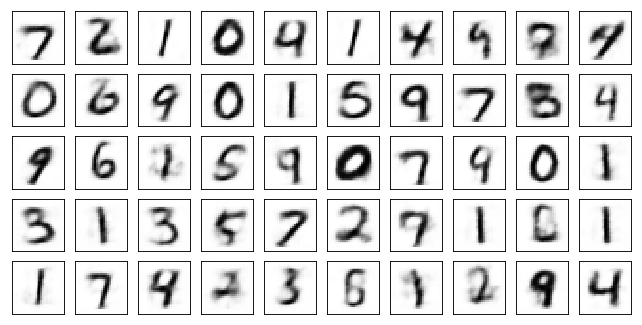

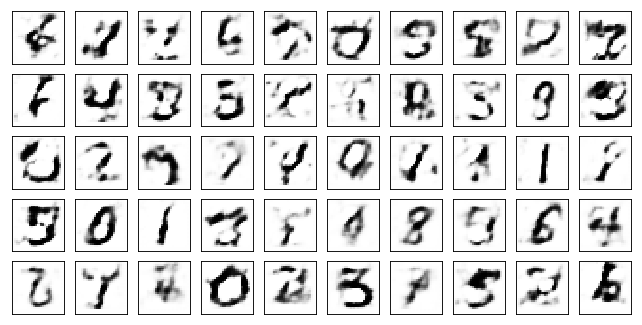

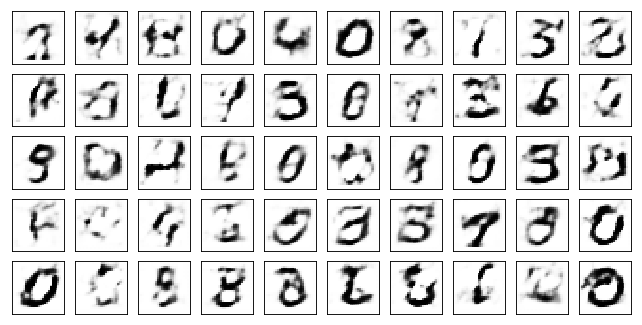

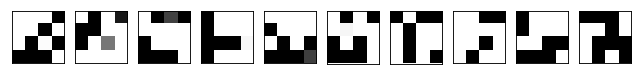

Model Adam Discr+dp:


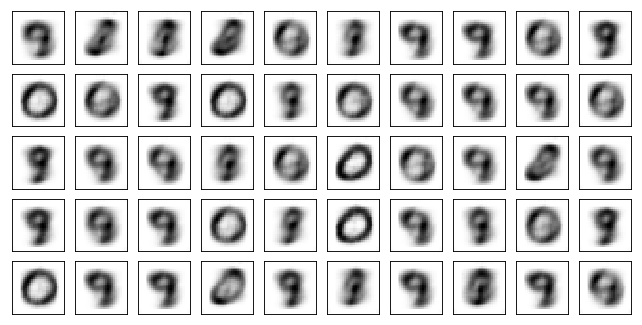

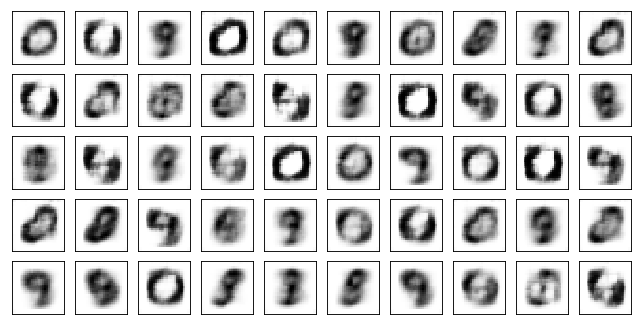

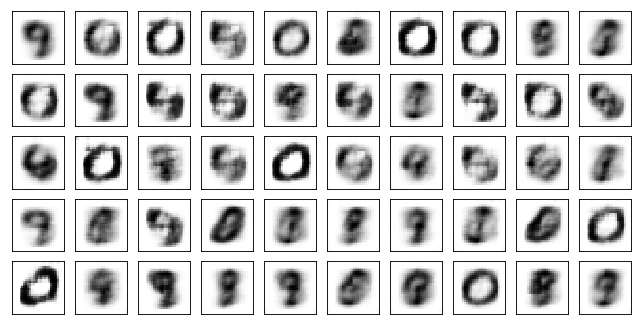

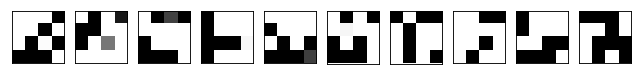

Model Adam Discr+bn+dp:


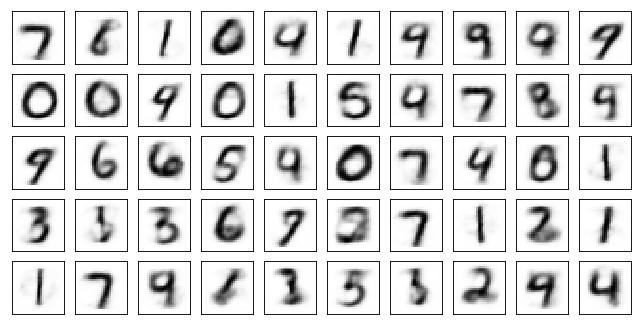

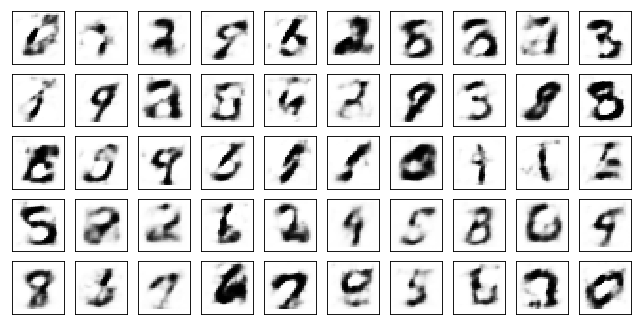

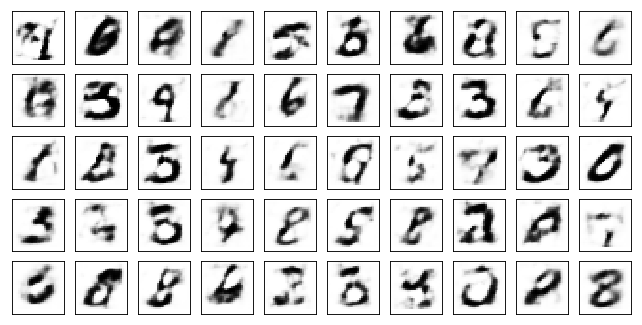

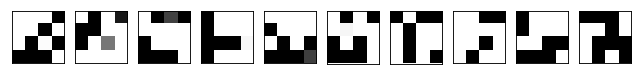

Test losses: 
Adam Discr+bn: 0.66474509 / 5.38188696 / 0.00117800 
Adam Discr+dp: 1.17407131 / 4.64638805 / 0.00343283 
Adam Discr+bn+dp: 0.70190984 / 5.89371014 / 0.00205405 

Train Epoch: 301 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1637 D:0.0002 Adam Discr+dp: AE:1.1151 D:0.0065 Adam Discr+bn+dp: AE:1.2988 D:0.0000
Train Epoch: 301 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1635 D:0.0000 Adam Discr+dp: AE:1.0449 D:0.0004 Adam Discr+bn+dp: AE:1.2454 D:0.0000
Train Epoch: 301 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2048 D:0.0001 Adam Discr+dp: AE:1.1148 D:0.0003 Adam Discr+bn+dp: AE:1.2710 D:0.0002
Test losses: 
Adam Discr+bn: 0.66937369 / 5.78106880 / 0.00313725 
Adam Discr+dp: 1.16358125 / 4.78691673 / 0.00360799 
Adam Discr+bn+dp: 0.70030820 / 5.86256266 / 0.00142335 

Train Epoch: 302 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.2334 D:0.0001 Adam Discr+dp: AE:1.1207 D:0.0002 Adam Discr+bn+dp: AE:1.2246 D:0.0001
Train Epoch: 302 [25000/50000 (50%)]	Losses Adam Discr+bn: 

Train Epoch: 314 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1233 D:0.0001 Adam Discr+dp: AE:1.1365 D:0.0002 Adam Discr+bn+dp: AE:1.2211 D:0.0000
Train Epoch: 314 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.1039 D:0.0001 Adam Discr+dp: AE:1.1773 D:0.0002 Adam Discr+bn+dp: AE:1.2756 D:0.0001
Test losses: 
Adam Discr+bn: 0.65112346 / 5.34320402 / 0.00120579 
Adam Discr+dp: 1.20540524 / 4.83542728 / 0.00270198 
Adam Discr+bn+dp: 0.71279687 / 5.74779654 / 0.00143547 

Train Epoch: 315 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.1177 D:0.0001 Adam Discr+dp: AE:1.1385 D:0.0001 Adam Discr+bn+dp: AE:1.1964 D:0.0001
Train Epoch: 315 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1168 D:0.0001 Adam Discr+dp: AE:1.1521 D:0.0001 Adam Discr+bn+dp: AE:1.1800 D:0.0001
Train Epoch: 315 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2782 D:0.0000 Adam Discr+dp: AE:1.1351 D:0.0002 Adam Discr+bn+dp: AE:1.2527 D:0.0001
Test losses: 
Adam Discr+bn: 0.66297776 / 5.80540466 / 0.00220419 
Adam Discr+dp:

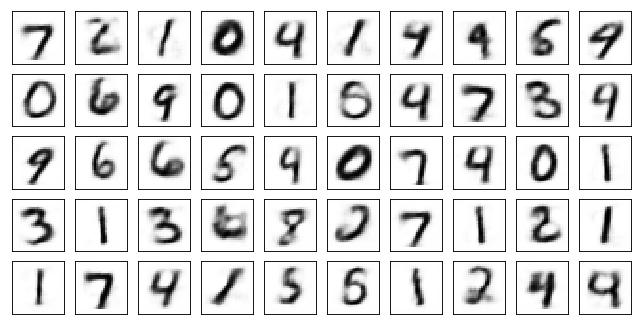

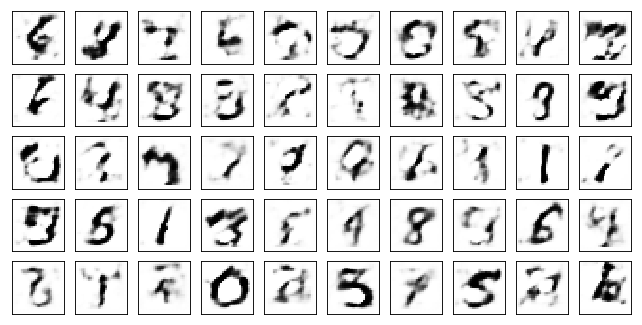

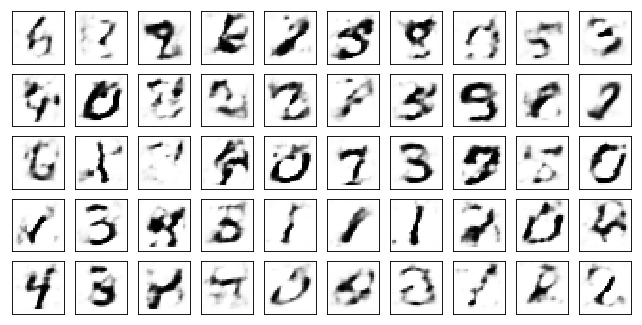

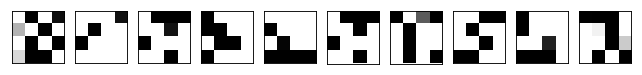

Model Adam Discr+dp:


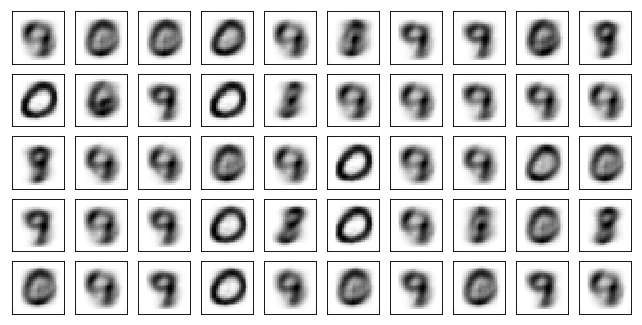

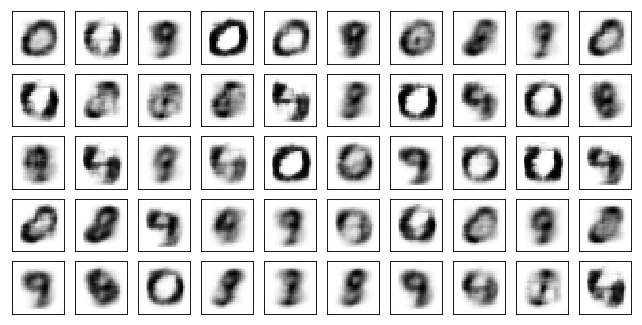

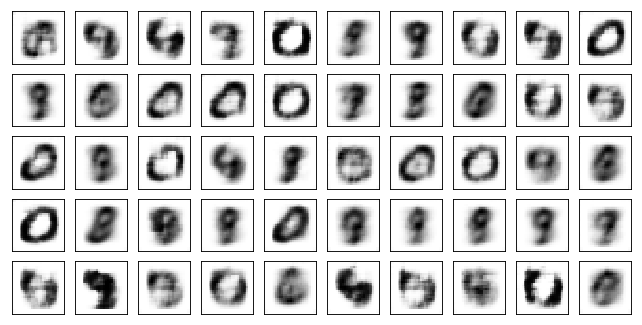

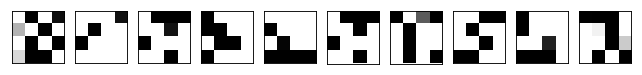

Model Adam Discr+bn+dp:


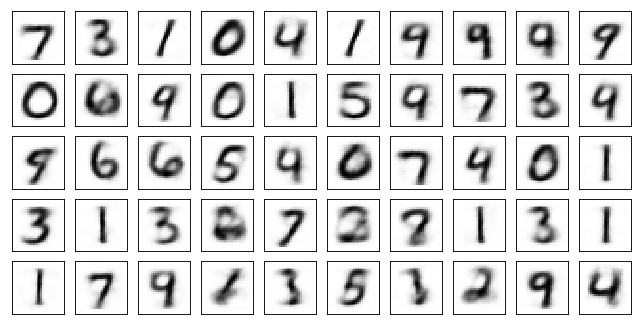

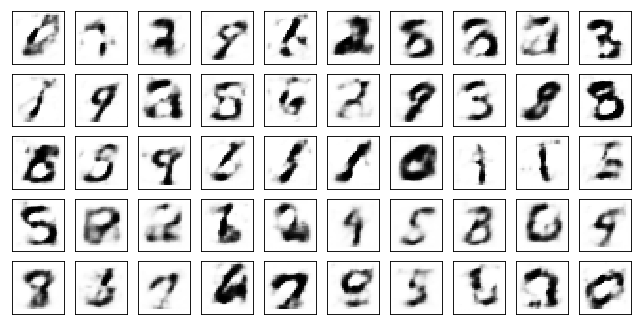

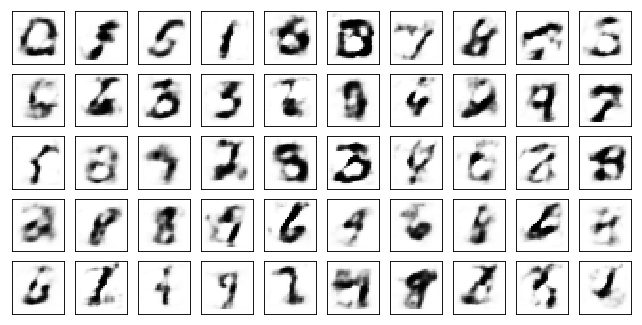

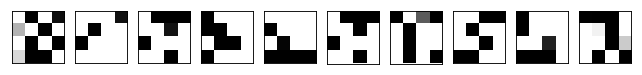

Test losses: 
Adam Discr+bn: 0.65809226 / 5.13713360 / 0.00277736 
Adam Discr+dp: 1.17330360 / 4.90776396 / 0.00392179 
Adam Discr+bn+dp: 0.70395970 / 5.68746281 / 0.00070837 

Train Epoch: 326 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0992 D:0.0002 Adam Discr+dp: AE:1.1397 D:0.0005 Adam Discr+bn+dp: AE:1.2346 D:0.0001
Train Epoch: 326 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.1968 D:0.0002 Adam Discr+dp: AE:1.1366 D:0.0003 Adam Discr+bn+dp: AE:1.2592 D:0.0001


KeyboardInterrupt: 

In [16]:
test_reveal_period = 25
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [ ]:
test_reveal_period = 1
for model in models.values():
    model.eval()
test(models, valid_loader, test_log)

In [ ]:
torch.save(models['Adam Discr+bn'], './adam_ds_bn_l16_1')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l16_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l16_1')

### Вывод результатов

In [ ]:
model = torch.load('./adam_ds_bndp_l16_1')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 16))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()